# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# Bayes sampler and pseudocell creation modules

##### Ver:: A0_V2_0
##### Author(s) : Issac Goh
##### Date : 231002;YYMMDD
### Author notes
- This set of modules first computes a series of learnt attention scores for each cell given a graph input
- These attention scores are then used to sample the data
- The aim of this sampling is to get a good representation of the data given prior knowledge provided from the graph
- We can then construct pseudocells using these sampled data points and the original graph
    
### Features to add
- Add ability to consume anndata zar format for sequential learning
### Modes to run in
- stratified
- unstratified

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


#¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INFO:   NOT AVAILABLE
I

In [6]:
models = {
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'YS_wget':'https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
}

adatas_dict = {
'pan_fetal_wget':'https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad',
'YS_wget':'https://app.cellatlas.io/yolk-sac/dataset/23/download',
'YS_local':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad',
'YS_pre_agm':'https://app.cellatlas.io/yolk-sac/dataset/10/download',
'FLIV_wget':'https://app.cellatlas.io/fetal-liver/dataset/1/download',
'int_atlas_sub':'/nfs/team298/ar32/Thesis_lab_hdca/label_testing_on_vae/scENTInEL/example_notebooks/Simple_sampled_adata_V1.h5ad',
'int_atlas_full':'/nfs/team298/ar32/Thesis_lab_hdca/from_kemal/14_dataset_with_leiden.h5ad',
}

#setup global params:
# Variable assignment
train_model = True
adata_key = 'YS_local'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'new_example_model'#'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
#dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = 'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
QC_normalise = False # should data be normalised?

# setup model parameters:
model_params = {
'feat_use': 'LVL3',
'train_x_partition' : 'X_scvi', # what partition was the data trained on?
'penalty':'elasticnet', # can be ["l1","l2","elasticnet"],
'var_length' : 7500,
'batch_key' : None,
'sparcity' : 0.5, #If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
'max_iter' : 1000, #Increase if experiencing max iter issues
'thread_num' : -1,
'l1_ratio' : 0.5, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
'partial_scale' : False, # should data be scaled in batches?
'tune_hyper_params' : True, # Current implementation is very expensive, intentionally made rigid for now
'batch_correction' : False,
'loss':'logloss',
'sketch_tune':False, # warning, do not use this if you are already sub-sampling
    
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':False,
'knn_key' : 'neighbors',
'sampling_rate': 0.1,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True,
'pl_label_entropy':False,
    
    
# Params for STGD-pagerank
'num_iterations': 1000,# How many mini-batches to learn
'mini_batch_size': 1000,# How large should each mini-batch be
'full_batch_update_iters': 100, # How many full batch updates
'n_hops' : 2, # How many neighborhood hops to assess -- this controls graph coverage
}

# Transductive workflow
- First we train a model on a subset of our data which we will then later use to generalise across our dataset.

- We sample our data using a set of empirical priors based on the known distribution of celltype labels, we then consider a weight to represent the liklihood of sampling by taking the sum of weights for each vertice sharing labels divided by vertices that have different labels. 

# Bayesian_balanced_stratified_sampling
This function, bayesian_balanced_stratified_sampling, performs stratified sampling on single-cell data stored in an AnnData object. It uses empirical Bayesian updating to balance the representation of each cell type (label) in the data. The sampling process considers the neighborhood relationships between cells, which helps maintain the local structure of the original data.

The sampling can be adjusted with several options, including:

equal_allocation: If enabled, each label gets an equal share of the total sample size. Otherwise, the sample size for each label is proportional to its prior probability.
replace: If enabled, sampling is done with replacement, allowing the model to create clones of cells.
iterations: Determines the number of times the sampling process is repeated, updating the label probabilities in each iteration.
The output is a new AnnData object containing the sampled cells and the indices of the sampled cells.

If left as default, underepresented states will naturally be prioritised in sampling as iterations increases, thus if you are experiencing issues with under representation, increase iterations. 

- Representation priority represents a wighting factor used to recover rare-states. 
- Prioritisation factor, this will heavily bias the sampling of under-represented states

# Using stratified sampling module with clones
- This module provides different attention metrics for local/global node importance measures
- Uses the prior distribution of cell-states as a prior for the sampling module
- Able to dynamically up-sample under-represented states if "replace==True"
- Penalises highly dense regions as sufficient information is available to resonctruct all relationships
- preserves the neighborhood structure so relationship to original graph is retained
- Prioritisation parameter forces the retention of known-rare states if they are subsequently removed by the sampler

In [7]:
# setup model parameters:
model_params = {
'feat_use': 'LVL3',
# Stratified Bayes sampler kwargs
'sample_data_knn':True,
'straify_sampling':True, # Whether to stratify the sampling by "feat_use" or not
'knn_key' : 'neighbors',
'sampling_rate': 0.025,# Apply empirical bayes sampling weighted by knn?
'weight_penalty': 'laplacian_SGD_pagerank', # Or 'entropy_distance' or "connectivity_ratio" or "laplacian" or "laplacian_SGD_pagerank"
'iterations': 10,#How many iterations of sampling to use for empirical bayes sampler? Probabilities update for each iteration and favour rare-states, increasing iter, naturally increases rare-sampling events
'representation_priority': 0.7, # This exponentially controls the sampling rate for rare-states, where 1 represents low-prioritisation, 0.1 represetns maximum prioritisation
'replace': True, # Allows model to clone cells
'equal_allocation': False, # Forces model to create equal representation sets
'resample_clones':True, # Reduce the number of clone cells where possible
'pl_label_entropy':False,
    
# Params for STGD-pagerank
'num_iterations': 1000,# How many mini-batches to learn
'mini_batch_size': 1000,# How large should each mini-batch be
'full_batch_update_iters': 100, # How many full batch updates
'n_hops' : 2, # How many neighborhood hops to assess -- this controls graph coverage
}

# A0.2.0 Update:
- For the unstratified sampling module, we should include graph summarisation metrics
- We should loop into epochs for each run of the SGDPR, carrying forward V_opt from previous epochs.

# A0.2.0 SGD_PGR update
- We remove the effect of learning rate on the first 50 iterations perhaps to improve training time


# Sampler update with mean-field ADVI methods
Method Summary:
Model Specification: The function models the attention scores using a Dirichlet distribution, which is a common choice for modeling probabilities. It captures the uncertainty in the attention scores.

Likelihood Function: A Categorical likelihood is used with the attention scores as observed data. This setup helps in estimating the underlying distribution of attention scores.

Variational Inference with ADVI: PyMC3's ADVI is used for approximating the posterior. ADVI is advantageous because it transforms the problem of Bayesian inference into an optimization problem, which is generally faster than sampling methods for large datasets.

Posterior Sampling: After fitting the model with ADVI, samples are drawn from the approximate posterior. These samples represent the estimated distribution of attention scores.

Efficiency: This method is computationally more efficient than traditional MCMC methods like HMC, especially for large datasets. It's faster because it avoids the computationally intensive process of sampling, instead using optimization to find a variational distribution that approximates the posterior.

Scalability: ADVI scales better to large datasets as it leverages gradient-based optimization, which can handle large data volumes more effectively than sampling-based methods.

Accuracy: While VI might be less accurate than MCMC in some cases, it provides a good balance between computational efficiency and accuracy, especially when the exact posterior is complex or when computational resources are limited.

Why Superior to np.random Sampling: Using VI provides a principled statistical approach to account for the uncertainty and structure in the data, unlike np.random sampling, which does not consider underlying data distributions or uncertainties.

Why Superior to Hamiltonian Methods: HMC can be very computationally intensive, especially for high-dimensional data or complex models. VI provides a faster alternative that is more suitable for large-scale applications, although it might sacrifice some accuracy.

In conclusion, this VI-based approach is suggested for scenarios where computational efficiency and scalability are crucial, and where a balance between speed and accuracy is desired. This method is particularly well-suited to large-scale data applications where traditional sampling methods might be prohibitively slow.

In [8]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)

# Dynamic Gaussian smoothing and resolution tweaks

- Updates to pagerank vector: 
    - Perhaps we should consider a multi-dimensional vector which is better representative of importance


In [9]:
def SGDpagerank(M, init_vect=None, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85,gamma_learn=50, tolerance=1e-6, d=0.85, 
             full_batch_update_iters=100, dip_window=5, plateau_iterations=5, sampling_method='probability_based',apply_gaussian_smoothing=True, **kwargs):
    """
    Calculate the PageRank of each node in a graph using a mini-batch SGD approach.

    Parameters:
    - M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
    - num_iterations (int): The maximum number of iterations to perform.
    - mini_batch_size (int): Number of nodes to sample in each iteration.
    - initial_learning_rate (float): Initial learning rate for the SGD updates.
    - tolerance (float): Convergence threshold.
    - d (float): Damping factor.
    - full_batch_update_iters (int): Number of iterations for the full-batch update phase.
    - dip_window (int): Window size for smoothing L2 norms.
    - plateau_iterations (int): Number of consecutive iterations where the gradient should remain stable for early stopping.
    - sampling_method (str): Method to sample nodes ('probability_based' or 'cyclic').

    Returns:
    - numpy.ndarray: The PageRank score for each node in the graph.
    - dict: L2 norms for each iteration.
    """
    # Unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())
        
    # Initialize the size of the matrix
    N = M.shape[1]
    
    # Apply Gaussian smoothing if enabled
    if apply_gaussian_smoothing:
        print("Applying Gaussian smoothing to input connectivity matrix")
        gaussian_kernel_std = 1
        M = gaussian_smoothing(M, gaussian_kernel_std)
    
    # Initialize PageRank vector with random values and normalize
    if init_vect is None:
        print("No pre-rank vector provided, proceeding with randomised intialisation")
        v = np.random.rand(N, 1)
        v = v / np.linalg.norm(v, 1)
    else:
        print("Pre-initialised vector provided")
        v = init_vect
    
    # Initialize last PageRank vector to infinity for convergence checks
    last_v = np.ones((N, 1)) * np.inf
    
    # Dictionary to store L2 norms for each iteration
    l2_dic = {}
    
    # Set to keep track of visited nodes (for cyclic sampling)
    visited_nodes = set()
    
    # Initialize counters and lists for plateau and dip detection
    plateau_count = 0
    dips_detected = 0
    dip_positions = []

    # Initialize an array to keep track of node visit counts (for probability-based sampling)
    visited_counts = np.zeros(N)

    for iter_ in range(num_iterations):
        
        # Add variable which only starts learning rate decay after gamma time
        if iter_ <= gamma_learn:
            learning_rate = 1
            
        else:
            # Decay the learning rate to ensure convergence
            learning_rate = initial_learning_rate / ((1 + iter_)/10)
        
        # Probability-based sampling
        if sampling_method == 'probability_based':
            probabilities = 1 / (1 + visited_counts)
            probabilities /= probabilities.sum()
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        # Cyclic sampling
        elif sampling_method == 'cyclic':
            if len(visited_nodes) < N:
                remaining_nodes = list(set(range(N)) - visited_nodes)
                mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
            else:
                mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
            # Update the set of visited nodes
            visited_nodes.update(mini_batch_indices)
        
        # Update node visit counts
        visited_counts[mini_batch_indices] += 1
        
        # Extract the mini-batch from the matrix and the PageRank vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices]
        
        # Store the current PageRank values for convergence checks
        last_v = v_mini_batch
        
        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rate * M_mini_batch @ v) + ((1 - d) / N)
        v[mini_batch_indices] = v_mini_batch
        
        # Compute and store the L2 norm of the difference between the current and last PageRank values
        if iter_ == gamma_learn:
            l2_dic[iter_] = l2_dic[iter_ - 1] # Discount L2 norm at point of learning rate initialisation
        else:
            l2_norm = np.linalg.norm(v_mini_batch - last_v)
            l2_dic[iter_] = l2_norm
        
        # Compute smoothed L2 norms for dip detection
        if iter_ > dip_window:
            smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
            gradient = smoothed_values[-1] - smoothed_values[-2]
            
            # Detect dips in the smoothed L2 norms
            if gradient < -1.5 * np.std(smoothed_values):
                dips_detected += 1
                dip_positions.append(iter_)

        # Check for convergence
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(iter_))
            break
        
        # Early stopping based on smoothed L2 norms
        gradient_variance_window = 10
        if iter_ > gradient_variance_window:
            gradient_values = np.diff(smoothed_values)
            variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
            if sampling_method == 'probability_based' and dips_detected == 1:
                if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            elif sampling_method == 'cyclic' and dips_detected > 1:
                if abs(gradient) < 0.5 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            # If the gradient has been stable for a number of iterations, stop early
            if plateau_count >= plateau_iterations:
                print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
                break

    # If the algorithm hasn't converged in the given number of iterations, display a message
    if iter_ == num_iterations-1:
        print('pagerank model did not converge during the mini-batch phase')
    
    # Refine the PageRank values using full-batch updates
    print("Proceeding on to perform fine-tuning across full-batch")
    for _ in range(full_batch_update_iters):
        # Decay the learning rate to ensure convergence
        learning_rate = initial_learning_rate / ((1 + _)/10)
        last_v_global = v.copy()
        v = d * (learning_rate* M @ v) + ((1 - d) / N)
        if _ == 0:
            l2_dic[iter_ + _ + 1] = l2_dic[iter_]# Discount L2 norm at point of global initialisation
        else:
            l2_norm_global = np.linalg.norm(v - last_v_global)
            l2_dic[iter_ + _ + 1] = l2_norm_global
    
    # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
    smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
    plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
#     for dip in dip_positions:
#         plt.axvline(x=dip, color='g', linestyle='--', label="Dip positions")
    plt.axvline(x=gamma_learn, color='g', linestyle='--', label="Learning rate decay intialisation")
    
    if plateau_count >= plateau_iterations:
        plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

    # Highlight the global fine-tuning iterations
    plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if sampling_method == 'probability_based':
        print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
        print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
    elif sampling_method == 'cyclic':
        print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
        print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    
    return v, l2_dic

Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
Converged at iteration 729
Proceeding on to perform fine-tuning across full-batch


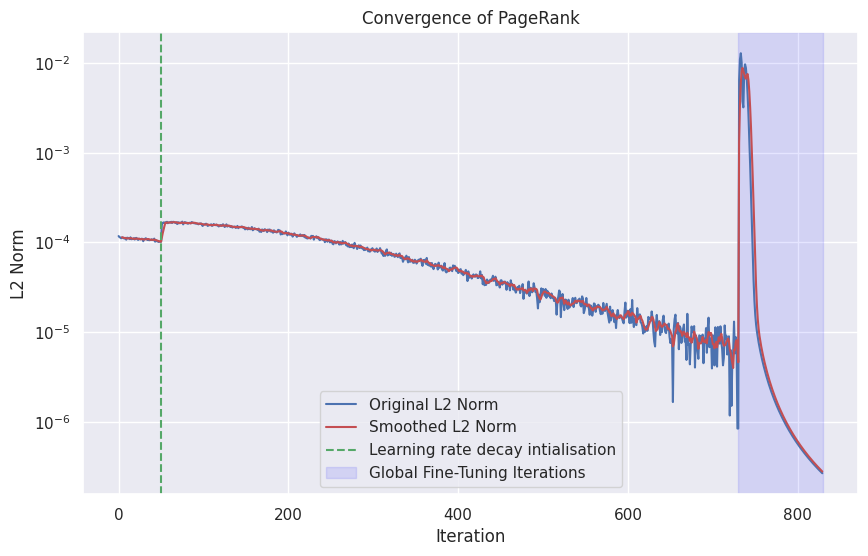

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!


In [10]:
from collections import Counter
import pymc3 as pm
import theano.tensor as tt

sampling_rate=0.1
model_params['straify_sampling'] = False
iterations=1
representation_priority = 0.9
equal_allocation=False
replace = True
weight_penalty='laplacian_SGD_pagerank'
pl_label_entropy=False
resample_clones=False
n_hops=2
apply_gaussian_smoothing = False

kwargs = model_params

if kwargs:
    for key, value in kwargs.items():
        globals()[key] = value
    kwargs.update(locals())

def hmc_sampling(attention_scores, total_sample_size, num_samples=100, tune=500, draws=1000):
    """
    Perform Hamiltonian Monte Carlo sampling given attention scores.

    Parameters:
    - attention_scores (numpy.ndarray): Array of attention scores.
    - total_sample_size (int): The total number of samples to draw.
    - num_samples (int): Number of times to repeat the HMC sampling process.
    - tune (int): Number of tuning steps for HMC.
    - draws (int): Number of draws from the posterior.

    Returns:
    - numpy.ndarray: Indices sampled using HMC.
    """

    # Normalize attention scores to use as probabilities in a categorical distribution
    attention_probs = attention_scores / attention_scores.sum()

    # Define a PyMC3 model
    with pm.Model() as model:
        # Define the categorical distribution based on attention scores
        category = pm.Categorical('category', p=attention_probs, shape=len(attention_scores))

        # Sample from the model using HMC
        trace = pm.sample(draws=draws, tune=tune, step=pm.HamiltonianMC())

    # Extract the samples
    samples = trace.get_values('category')

    # Choose 'num_samples' number of samples from the HMC output
    sampled_indices = np.random.choice(samples, size=num_samples, replace=False)

    return sampled_indices
    
# def SGDpagerank(M, init_vect=None, num_iterations=1000, mini_batch_size=1000, initial_learning_rate=0.85,gamma_learn=50, tolerance=1e-6, d=0.85, 
#              full_batch_update_iters=100, dip_window=5, plateau_iterations=5, sampling_method='probability_based',apply_gaussian_smoothing=True, **kwargs):
#     """
#     Calculate the PageRank of each node in a graph using a mini-batch SGD approach.

#     Parameters:
#     - M (scipy.sparse.csr_matrix): The adjacency matrix of the graph.
#     - num_iterations (int): The maximum number of iterations to perform.
#     - mini_batch_size (int): Number of nodes to sample in each iteration.
#     - initial_learning_rate (float): Initial learning rate for the SGD updates.
#     - tolerance (float): Convergence threshold.
#     - d (float): Damping factor.
#     - full_batch_update_iters (int): Number of iterations for the full-batch update phase.
#     - dip_window (int): Window size for smoothing L2 norms.
#     - plateau_iterations (int): Number of consecutive iterations where the gradient should remain stable for early stopping.
#     - sampling_method (str): Method to sample nodes ('probability_based' or 'cyclic').

#     Returns:
#     - numpy.ndarray: The PageRank score for each node in the graph.
#     - dict: L2 norms for each iteration.
#     """
#     # Unpack kwargs
#     if kwargs:
#         for key, value in kwargs.items():
#             globals()[key] = value
#         kwargs.update(locals())
        
#     # Initialize the size of the matrix
#     N = M.shape[1]
    
#     # Apply Gaussian smoothing if enabled
#     if apply_gaussian_smoothing:
#         print("Applying Gaussian smoothing to input connectivity matrix")
#         gaussian_kernel_std = 1
#         M = gaussian_smoothing(M, gaussian_kernel_std)
    
#     # Initialize PageRank vector with random values and normalize
#     if init_vect is None:
#         print("No pre-rank vector provided, proceeding with randomised intialisation")
#         v = np.random.rand(N, 1)
#         v = v / np.linalg.norm(v, 1)
#     else:
#         print("Pre-initialised vector provided")
#         v = init_vect
    
#     # Initialize last PageRank vector to infinity for convergence checks
#     last_v = np.ones((N, 1)) * np.inf
    
#     # Dictionary to store L2 norms for each iteration
#     l2_dic = {}
    
#     # Set to keep track of visited nodes (for cyclic sampling)
#     visited_nodes = set()
    
#     # Initialize counters and lists for plateau and dip detection
#     plateau_count = 0
#     dips_detected = 0
#     dip_positions = []

#     # Initialize an array to keep track of node visit counts (for probability-based sampling)
#     visited_counts = np.zeros(N)

#     for iter_ in range(num_iterations):
        
#         # Add variable which only starts learning rate decay after gamma time
#         if iter_ <= gamma_learn:
#             learning_rate = 1
#         else:
#             # Decay the learning rate to ensure convergence
#             learning_rate = initial_learning_rate / ((1 + iter_)/10)
        
#         # Probability-based sampling
#         if sampling_method == 'probability_based':
#             probabilities = 1 / (1 + visited_counts)
#             probabilities /= probabilities.sum()
#             mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
#         # Cyclic sampling
#         elif sampling_method == 'cyclic':
#             if len(visited_nodes) < N:
#                 remaining_nodes = list(set(range(N)) - visited_nodes)
#                 mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
#             else:
#                 mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
#             # Update the set of visited nodes
#             visited_nodes.update(mini_batch_indices)
        
#         # Update node visit counts
#         visited_counts[mini_batch_indices] += 1
        
#         # Extract the mini-batch from the matrix and the PageRank vector
#         M_mini_batch = M[mini_batch_indices, :]
#         v_mini_batch = v[mini_batch_indices]
        
#         # Store the current PageRank values for convergence checks
#         last_v = v_mini_batch
        
#         # Update the PageRank values using the mini-batch
#         v_mini_batch = d * (learning_rate * M_mini_batch @ v) + ((1 - d) / N)
#         v[mini_batch_indices] = v_mini_batch
        
#         # Compute and store the L2 norm of the difference between the current and last PageRank values
#         l2_norm = np.linalg.norm(v_mini_batch - last_v)
#         l2_dic[iter_] = l2_norm
        
#         # Compute smoothed L2 norms for dip detection
#         if iter_ > dip_window:
#             smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
#             gradient = smoothed_values[-1] - smoothed_values[-2]
            
#             # Detect dips in the smoothed L2 norms
#             if gradient < -1.5 * np.std(smoothed_values):
#                 dips_detected += 1
#                 dip_positions.append(iter_)

#         # Check for convergence
#         if l2_norm < tolerance:
#             print('Converged at iteration {}'.format(iter_))
#             break
        
#         # Early stopping based on smoothed L2 norms
#         gradient_variance_window = 10
#         if iter_ > gradient_variance_window:
#             gradient_values = np.diff(smoothed_values)
#             variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
#             if sampling_method == 'probability_based' and dips_detected == 1:
#                 if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
#                     plateau_count += 1
#                 else:
#                     plateau_count = 0

#             elif sampling_method == 'cyclic' and dips_detected > 1:
#                 if abs(gradient) < 0.5 * variance_of_gradient:
#                     plateau_count += 1
#                 else:
#                     plateau_count = 0

#             # If the gradient has been stable for a number of iterations, stop early
#             if plateau_count >= plateau_iterations:
#                 print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
#                 break

#     # If the algorithm hasn't converged in the given number of iterations, display a message
#     if iter_ == num_iterations-1:
#         print('pagerank model did not converge during the mini-batch phase')
    
#     # Refine the PageRank values using full-batch updates
#     print("Proceeding on to perform fine-tuning across full-batch")
#     for _ in range(full_batch_update_iters):
#         # Decay the learning rate to ensure convergence
#         learning_rate = initial_learning_rate / ((1 + _)/10)
#         last_v_global = v.copy()
#         v = d * (learning_rate* M @ v) + ((1 - d) / N)
#         l2_norm_global = np.linalg.norm(v - last_v_global)
#         l2_dic[iter_ + _ + 1] = l2_norm_global
    
#     # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
#     plt.figure(figsize=(10,6))
#     plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
#     smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
#     plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
# #     for dip in dip_positions:
# #         plt.axvline(x=dip, color='g', linestyle='--', label="Dip positions")
#     plt.axvline(x=gamma_learn, color='g', linestyle='--', label="Learning rate decay intialisation")
    
#     if plateau_count >= plateau_iterations:
#         plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

#     # Highlight the global fine-tuning iterations
#     plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

#     plt.yscale("log")
#     plt.xlabel('Iteration')
#     plt.ylabel('L2 Norm')
#     plt.title('Convergence of PageRank')
#     plt.legend()
#     plt.grid(True)
#     plt.show()
    
#     if sampling_method == 'probability_based':
#         print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
#         print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
#     elif sampling_method == 'cyclic':
#         print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
#         print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    
#     return v, l2_dic
    
print('Non-stratified sampling based on attention weights chosen')

if representation_priority > 0.8:
    print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
    warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

#Experimental feature with 1 hop matrix
#neighborhood_matrix = neighborhood_matrix**n_hops ## N hops shopuld be added as an option in next iter. this controls the coverage of the graph

# Calculate total sample size and sample size per label for equal allocation
total_sample_size = int(sampling_rate * adata.shape[0])
#     sample_size_per_label = total_sample_size // len(unique_labels)

if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = SGDpagerank(csr_matrix, **kwargs) #num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100,

print("proceeding to 2 stage sampling using attention scores as priors")
attention_scores = attention_scores*(1*10**6)
# Add the attention scores to the observation dataframe
adata.obs['sf_attention'] = attention_scores

# Iterate over each unique stratifying variable
# for n in adata.obs[strat_var].unique():
tmp_obs = adata.obs#[adata.obs[strat_var] == n]
indices = range(len(tmp_obs))
attention_scores_tmp = tmp_obs['sf_attention']

# Apply softmax to attention scores
e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
sf_attention = e_v / e_v.sum()

# Calculate total sample size
total_sample_size = int(sampling_rate * len(tmp_obs))

# Initialize list to store all sampled indices
all_sampled_indices = []

# Conduct sampling N times (100 by default)
# N = 100
# for i in range(N):
#     sampled_indices = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)
#     all_sampled_indices.extend(sampled_indices)

# # Count the frequency of each index
# index_freq = Counter(all_sampled_indices)

# # Convert the frequencies to probabilities
# total_samples = sum(index_freq.values())
# sampling_probabilities = {index: freq / total_samples for index, freq in index_freq.items()}

# # Convert dictionary keys and values to lists for sampling
# sample_indices = list(sampling_probabilities.keys())
# sample_probs = list(sampling_probabilities.values())

# sampled_indices_from_output = np.random.choice(sample_indices, size=total_sample_size, p=sample_probs, replace=False)


# Hamiltonian monte carlo update block


# adata_samp = adata[sampled_indices_from_output]
print("Sampling complete!")


# adata_samp
# sampling_probabilities
# attention_scores

In [363]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

def vi_approximation(attention_scores, total_sample_size, num_samples=1000):
    """
    Estimate posterior using Variational Inference given softmax-transformed attention scores.

    Parameters:
    - attention_scores (numpy.ndarray): Softmax-transformed attention scores.
    - total_sample_size (int): Total number of samples to draw.
    - num_samples (int): Number of posterior samples to draw after VI.

    Returns:
    - numpy.ndarray: Indices sampled based on the estimated posterior.
    """

    with pm.Model() as model:
        # Assume a Dirichlet distribution for attention scores
        alphas = np.ones(len(attention_scores))  # Prior for Dirichlet
        probs = pm.Dirichlet('probs', a=alphas)

        # Define observed data with a categorical likelihood
        observations = pm.Categorical('observations', p=probs, observed=attention_scores)

        # Perform variational inference using ADVI
        approx = pm.fit(method='advi', n=50000)  # n is the number of ADVI iterations

    # Draw samples from the approximate posterior
    advi_samples = approx.sample(draws=num_samples)

    # Extract the indices from the samples
    sampled_indices = np.random.choice(np.arange(len(attention_scores)), size=total_sample_size, p=advi_samples['probs'].mean(axis=0))

    return sampled_indices


(array([4.1600e+02, 3.3939e+04, 6.4143e+04, 4.4011e+04, 1.9653e+04,
        6.0280e+03, 1.1880e+03, 1.0600e+02, 8.0000e+00, 2.0000e+00]),
 array([5.73581522e-06, 5.79184794e-06, 5.84788066e-06, 5.90391338e-06,
        5.95994610e-06, 6.01597882e-06, 6.07201154e-06, 6.12804426e-06,
        6.18407698e-06, 6.24010970e-06, 6.29614242e-06]),
 <BarContainer object of 10 artists>)

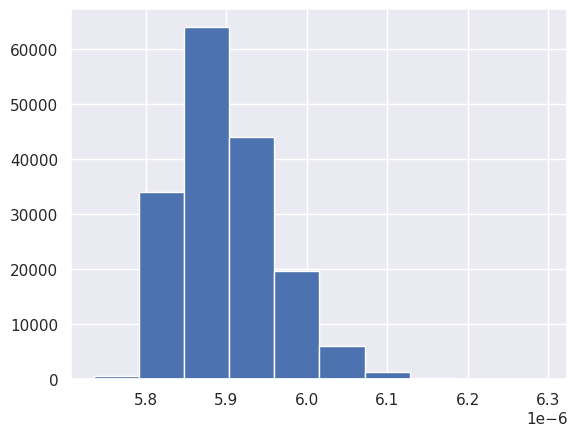

In [364]:
plt.hist(sf_attention)

In [365]:
VI_ind = vi_approximation(sf_attention, total_sample_size, num_samples=100)


KeyboardInterrupt



In [ ]:
attention_scores

In [9]:
kwargs['mini_batch_size'] = 1000
kwargs['num_iterations'] = 1000# How many mini-batches to learn
kwargs['full_batch_update_iters'] = 100 # How many full batch updates
kwargs['initial_learning_rate']=0.85
kwargs['gamma_learn']=100

Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
Converged at iteration 802
Proceeding on to perform fine-tuning across full-batch


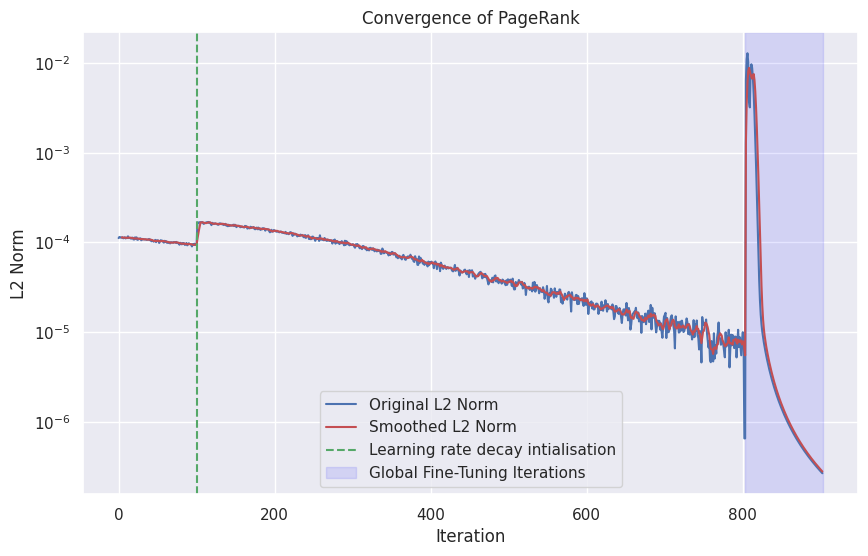

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement


In [10]:
if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = SGDpagerank(csr_matrix, **kwargs) #num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100,


# A0.2.1 SGD_PGR update:

# Bayesian Approach to Graph Topology Analysis Using Modified PageRank

- Attempt to learn multidimensional gaussian distribution which encodes topology of the graph
- We intriduce a GP model to learn from this multidimensional process and predict node importance.

**Modifying the Prototype Code**
- Initialization of Multidimensional Vector:

    Initialize v as an MxN matrix where M is the number of nodes and N is the dimensionality of the vector for each node.
- Introducing ReLU Activation:

    Apply the ReLU activation function to the updated PageRank scores (v) after each iteration.
- Adjusting L2 Norm Calculation:

    Modify the L2 norm calculation to handle the multidimensional array.
- Output Processing for Gaussian Process:

    After the iterative process, use the final v matrix as input to a Gaussian Process model.
    The GP model will output a probability distribution for node importance.
    Sample a set of nodes based on this distribution.

In [11]:
from collections import Counter
import pymc3 as pm
import theano.tensor as tt
import numpy as np
#import GPy
import numpy as np
from scipy.linalg import orth
from scipy.stats import nbinom
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

sampling_rate=0.1
model_params['straify_sampling'] = False
iterations=1
representation_priority = 0.9
equal_allocation=False
replace = True
weight_penalty='laplacian_SGD_pagerank'
pl_label_entropy=False
resample_clones=False
n_hops=2
apply_gaussian_smoothing = False
gamma_learn = 50

M = csr_matrix.copy()
init_vect = None
sampling_method = 'probability_based'
initial_learning_rate = 0.85
d = 0.85

full_batch_update_iters = 5

init_type = "sparse"
latent_dim = 5

# Initialization
# Function for Zero-Inflated Negative Binomial Sample
def zero_inflated_nbinom_sample(r, p, zero_inflation_prob, size):
    is_zero = np.random.rand(*size) < zero_inflation_prob
    return is_zero * nbinom.rvs(r, p, size=size)

# Initialization options
def initialize_vector(N, dimensions, init_type='uniform', normalize=False):
    if init_type == 'uniform':
        return np.random.rand(N, dimensions)
    elif init_type == 'normal':
        return np.random.randn(N, dimensions)
    elif init_type == 'xavier':
        std_dev = np.sqrt(2 / (N + dimensions))
        return np.random.normal(0, std_dev, (N, dimensions))
    elif init_type == 'he':
        std_dev = np.sqrt(2 / N)
        return np.random.normal(0, std_dev, (N, dimensions))
    elif init_type == 'orthogonal':
        big_matrix = np.random.randn(max(N, dimensions), max(N, dimensions))
        return orth(big_matrix)[:N, :dimensions]
    elif init_type == 'sparse':
        density = 0.1
        v = np.random.choice([0, 1], size=(N, dimensions), p=[1-density, density])
        v = v * np.random.randn(N, dimensions)
        if normalize:
            v = v / np.linalg.norm(v, ord=1, axis=0)
        return v
    elif init_type == 'custom':
        return np.random.uniform(-0.5, 0.5, (N, dimensions))
    elif init_type == 'negative_binomial':
        r, p = 10, 0.5  # Example parameters
        return nbinom.rvs(r, p, size=(N, dimensions))
    elif init_type == 'zero_inflated_negative_binomial':
        r, p, zero_inflation_prob = 10, 0.5, 0.2  # Example parameters
        return zero_inflated_nbinom_sample(r, p, zero_inflation_prob, size=(N, dimensions))
    else:
        raise ValueError("Unknown initialization type.")
        
def softplus(x):
    return np.log(1 + np.exp(x))
def ReLU(x):
    return np.maximum(x, 0)

N, dimensions = N, latent_dim
v_init = initialize_vector(N, dimensions, init_type='normal', normalize=False)
v = v_init.copy()
#v = v / np.linalg.norm(v, ord=1, axis=0)  # Normalize along each dimension

# PageRank with ReLU and multidimensional vectors
for _ in range(full_batch_update_iters):
    learning_rate = initial_learning_rate / ((1 + _)/10)
    last_v_global = v.copy()
    
    # Update PageRank scores
    v = d * (M @ v) + ((1 - d) / N)
    
    # Apply ReLU activation
    v = softplus(v)  # ReLU/softplus

    # Update L2 norm for each dimension
    l2_norm_global = np.linalg.norm(v - last_v_global, ord=2, axis=0)
    l2_dic[iter_ + _ + 1] = l2_norm_global

NameError: name 'N' is not defined

In [377]:
v_init = initialize_vector(N, dimensions, init_type='normal', normalize=False)
v_init

array([[ 1.52980966, -0.32029541,  1.17863201, -1.21723097,  0.88237678],
       [ 0.13351165,  0.62242305,  0.89964445, -1.1555113 , -1.53220416],
       [ 0.72776373, -1.19802002,  0.23567818, -0.42201504, -1.03723268],
       ...,
       [ 1.10505203, -0.73544587,  0.83376948,  0.1101633 ,  0.10029347],
       [-0.46503265,  0.1817564 , -0.58548243,  0.48527215, -1.19815279],
       [-0.59600782,  0.61154695, -1.46752262, -0.82564475,  0.09419194]])

In [10]:
adata =  scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
neighborhood_matrix = adata.obsp['connectivities']

In [34]:
kwargs['num_iterations'] = 100

Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
No pre-rank vector provided, proceeding with randomised intialisation
pagerank model did not converge during the mini-batch phase
Proceeding on to perform fine-tuning across full-batch


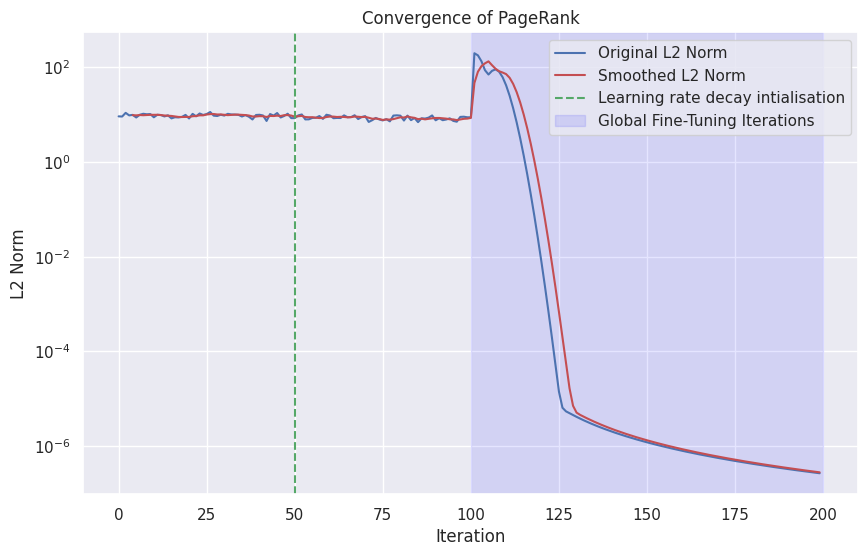

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement


In [35]:
from collections import Counter
import pymc3 as pm
import theano.tensor as tt
import numpy as np
#import GPy
import numpy as np
from scipy.linalg import orth
from scipy.stats import nbinom
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics.pairwise import cosine_similarity

#######
sampling_rate=0.1
model_params['straify_sampling'] = False
iterations=1
representation_priority = 0.9
equal_allocation=False
replace = True
weight_penalty='laplacian_SGD_pagerank'
pl_label_entropy=False
resample_clones=False
n_hops=2
apply_gaussian_smoothing = False
gamma_learn = 50


###test specific###
M = csr_matrix.copy()
init_vect = None
sampling_method = 'probability_based'
initial_learning_rate = 0.85
d = 0.85
dip_window=5
init_vect=None
num_iterations=100
mini_batch_size=10000
initial_learning_rate=0.85
gamma_learn=50
tolerance=1e-6
d=0.85
full_batch_update_iters=10
dip_window=5
plateau_iterations=5
sampling_method='probability_based'
apply_gaussian_smoothing=False
###

###mods###

###new###
init_type = "sparse"
latent_dim = 2
N = M.shape[1]
N, dimensions = N, latent_dim
###new###


neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

#Experimental feature with 1 hop matrix
#neighborhood_matrix = neighborhood_matrix**n_hops ## N hops shopuld be added as an option in next iter. this controls the coverage of the graph

# Calculate total sample size and sample size per label for equal allocation
total_sample_size = int(sampling_rate * adata.shape[0])
#     sample_size_per_label = total_sample_size // len(unique_labels)

if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()

# Unpack kwargs
if kwargs:
    for key, value in kwargs.items():
        globals()[key] = value
    kwargs.update(locals())

# Initialize the size of the matrix
N = M.shape[1]

# Apply Gaussian smoothing if enabled
if apply_gaussian_smoothing:
    print("Applying Gaussian smoothing to input connectivity matrix")
    gaussian_kernel_std = 1
    M = gaussian_smoothing(M, gaussian_kernel_std)

# Initialize PageRank vector with random values and normalize
if init_vect is None:
    print("No pre-rank vector provided, proceeding with randomised intialisation")
    v_init = initialize_vector(N, dimensions, init_type=init_type, normalize=False)
    v = v_init.copy()
else:
    print("Pre-initialised vector provided")
    v = init_vect

# Initialize last PageRank vector to infinity for convergence checks
last_v = v #np.ones((N, 1)) * np.inf

# Dictionary to store L2 norms for each iteration
l2_dic = {}

# Set to keep track of visited nodes (for cyclic sampling)
visited_nodes = set()

# Initialize counters and lists for plateau and dip detection
plateau_count = 0
dips_detected = 0
dip_positions = []

# Initialize an array to keep track of node visit counts (for probability-based sampling)
visited_counts = np.zeros(N)

cos_sim_values = []
window_size = 20 
for iter_ in range(num_iterations):

    # Add variable which only starts learning rate decay after gamma time
    if iter_ <= gamma_learn:
        learning_rate = 1
        # Initialize learning rates for each latent vector
        learning_rates = np.ones(latent_dim) * initial_learning_rate

    else:
        # Decay the learning rate decay to ensure convergence
        learning_rate = initial_learning_rate / ((1 + iter_)/10)
        # Initialize learning rates for each latent vector
        learning_rates = np.ones(latent_dim) * initial_learning_rate

    # Probability-based sampling
    selective_batch_size = mini_batch_size * latent_dim ## Increase mini-batch size for selective sampling
    if sampling_method == 'probability_based':
        probabilities = 1 / (1 + visited_counts)
#         probabilities /= probabilities.sum()
#        mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        probabilities /= probabilities.sum()
        selective_batch_indices = np.random.choice(N, size=selective_batch_size, replace=False, p=probabilities)


    # Cyclic sampling
    elif sampling_method == 'cyclic':
        if len(visited_nodes) < N:
            remaining_nodes = list(set(range(N)) - visited_nodes)
            mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
        else:
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)

        # Update the set of visited nodes
        visited_nodes.update(mini_batch_indices)

    # Process each latent vector separately
    for i in range(latent_dim):
        # Select a different subset of the batch for each vector
        start_idx = i * mini_batch_size
        end_idx = start_idx + mini_batch_size
        mini_batch_indices = selective_batch_indices[start_idx:end_idx]

        # Extract the mini-batch for the current vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices, i]

        # Update node visit counts
        visited_counts[mini_batch_indices] += 1

#     # Extract the mini-batch from the matrix and the PageRank vector
#     M_mini_batch = M[mini_batch_indices, :]
#     v_mini_batch = v[mini_batch_indices]

        # Store the current PageRank values for convergence checks
        last_v = v_mini_batch

        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rates[i] * M_mini_batch @ v[:, i]) + ((1 - d) / N)
        v[mini_batch_indices, i] = v_mini_batch

    # Compute and store the L2 norm of the difference between the current and last PageRank values
    if iter_ == gamma_learn:
        l2_dic[iter_] = l2_dic[iter_ - 1] # Discount L2 norm at point of learning rate initialisation
    else:
        l2_norm = np.mean(np.linalg.norm(v_mini_batch - last_v, ord=2, axis=0))
        l2_dic[iter_] = l2_norm  
        
        
    # Compute smoothed L2 norms for dip detection
    if iter_ > dip_window:
        smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
        gradient = smoothed_values[-1] - smoothed_values[-2]

        # Detect dips in the smoothed L2 norms
        if gradient < -1.5 * np.std(smoothed_values):
            dips_detected += 1
            dip_positions.append(iter_)

    # Check for convergence
    if l2_norm < tolerance:
        print('Converged at iteration {}'.format(iter_))
        break
        
     # Update the moving average after gamma_learn iterations
    if iter_ > gamma_learn:
        for i in range(latent_dim):
            for j in range(i + 1, latent_dim):
                vector_i = v[:, i].reshape(1, -1)
                vector_j = v[:, j].reshape(1, -1)
                cos_sim = cosine_similarity(vector_i, vector_j)[0, 0]

                # Update the list of cosine similarities
                cos_sim_values.append(cos_sim)
                if len(cos_sim_values) > window_size:
                    cos_sim_values.pop(0)

                # Calculate dynamic threshold as a moving average
                dynamic_threshold = np.mean(cos_sim_values)

                # Increase learning rate based on dynamic threshold
                if cos_sim > dynamic_threshold:
                    learning_rates[i] *= 1.05


    # Early stopping based on smoothed L2 norms
    gradient_variance_window = 10
    if iter_ > gradient_variance_window:
        gradient_values = np.diff(smoothed_values)
        variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])

        if sampling_method == 'probability_based' and dips_detected == 1:
            if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                plateau_count += 1
            else:
                plateau_count = 0

        elif sampling_method == 'cyclic' and dips_detected > 1:
            if abs(gradient) < 0.5 * variance_of_gradient:
                plateau_count += 1
            else:
                plateau_count = 0

        # If the gradient has been stable for a number of iterations, stop early
        if plateau_count >= plateau_iterations:
            print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
            break

# If the algorithm hasn't converged in the given number of iterations, display a message
if iter_ == num_iterations-1:
    print('pagerank model did not converge during the mini-batch phase')

# Refine the PageRank values using full-batch updates
print("Proceeding on to perform fine-tuning across full-batch")
for _ in range(full_batch_update_iters):
    # Decay the learning rate to ensure convergence
    learning_rate = initial_learning_rate / ((1 + _)/10)
    last_v_global = v.copy()
    v = d * (learning_rate* M @ v) + ((1 - d) / N)
    if _ == 0:
        l2_dic[iter_ + _ + 1] = l2_dic[iter_]# Discount L2 norm at point of global initialisation
    else:
        l2_norm_global = np.mean(np.linalg.norm(v - last_v_global, ord=2, axis=0))
        l2_dic[iter_ + _ + 1] = l2_norm_global

# Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
plt.figure(figsize=(10,6))
plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")

#     for dip in dip_positions:
#         plt.axvline(x=dip, color='g', linestyle='--', label="Dip positions")
plt.axvline(x=gamma_learn, color='g', linestyle='--', label="Learning rate decay intialisation")

if plateau_count >= plateau_iterations:
    plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

# Highlight the global fine-tuning iterations
plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('L2 Norm')
plt.title('Convergence of PageRank')
plt.legend()
plt.grid(True)
plt.show()

if sampling_method == 'probability_based':
    print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
    print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
elif sampling_method == 'cyclic':
    print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
    print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")

In [41]:
e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
sf_attention = e_v / e_v.sum()

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [43]:
v[:,0]*10**6

array([0.94539972, 0.94060465, 0.94817376, ..., 0.93500776, 0.96918002,
       0.94535838])

In [36]:
pl = adata[adata.obs['v_1']>(np.mean(adata.obs['v_1']) + (np.std(adata.obs['v_1'])*1))]
print(set(pl.obs['LVL3']) ^ set(adata.obs['LVL3']))
sc.pl.umap(pl,color = ['v_1','LVL3'])

KeyError: 'v_1'

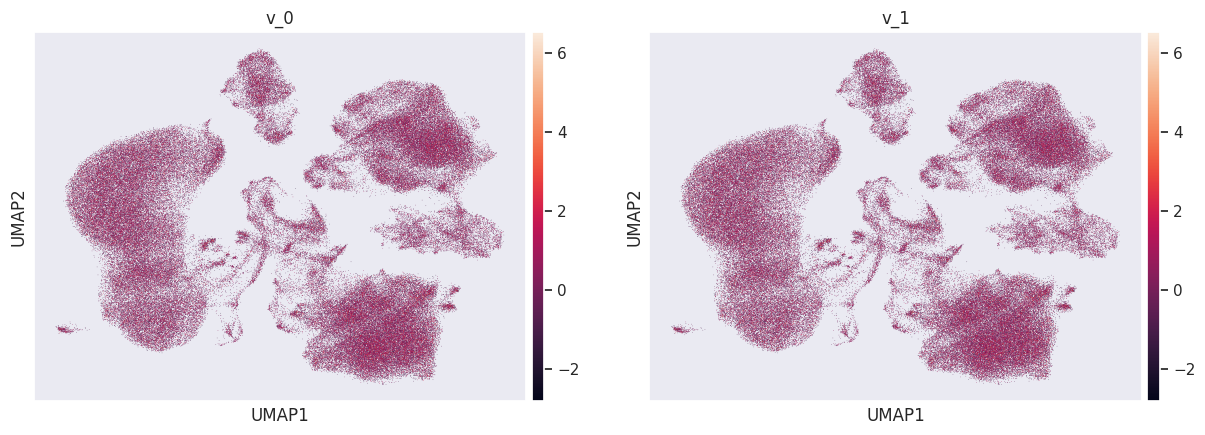

In [44]:
sc.pl.umap(adata,color = ['v_0','v_1'])

(array([3.0500e+02, 2.9156e+04, 6.3448e+04, 4.5992e+04, 2.1995e+04,
        6.9800e+03, 1.4640e+03, 1.4100e+02, 1.1000e+01, 2.0000e+00]),
 array([9.16318299e-07, 9.25639023e-07, 9.34959748e-07, 9.44280472e-07,
        9.53601196e-07, 9.62921921e-07, 9.72242645e-07, 9.81563369e-07,
        9.90884094e-07, 1.00020482e-06, 1.00952554e-06]),
 <BarContainer object of 10 artists>)

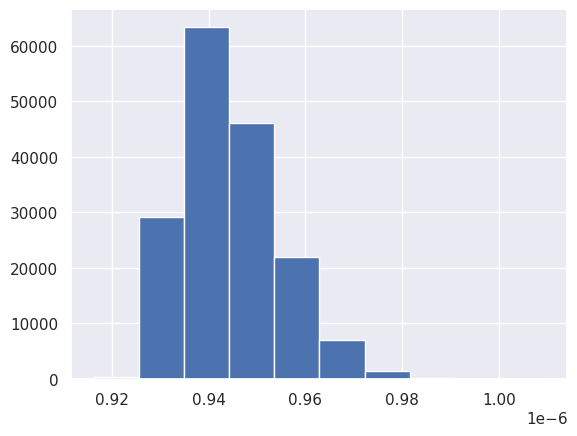

In [40]:
plt.hist(v[:,0])

(array([[3.0500e+02, 2.9156e+04, 6.3448e+04, 4.5992e+04, 2.1995e+04,
         6.9800e+03, 1.4640e+03, 1.4100e+02, 1.1000e+01, 2.0000e+00],
        [3.0500e+02, 2.9156e+04, 6.3448e+04, 4.5992e+04, 2.1995e+04,
         6.9800e+03, 1.4640e+03, 1.4100e+02, 1.1000e+01, 2.0000e+00],
        [3.0500e+02, 2.9156e+04, 6.3448e+04, 4.5992e+04, 2.1995e+04,
         6.9800e+03, 1.4640e+03, 1.4100e+02, 1.1000e+01, 2.0000e+00],
        [3.0500e+02, 2.9156e+04, 6.3448e+04, 4.5992e+04, 2.1995e+04,
         6.9800e+03, 1.4640e+03, 1.4100e+02, 1.1000e+01, 2.0000e+00],
        [3.0500e+02, 2.9156e+04, 6.3448e+04, 4.5992e+04, 2.1995e+04,
         6.9800e+03, 1.4640e+03, 1.4100e+02, 1.1000e+01, 2.0000e+00]]),
 array([9.16318299e-07, 9.25639023e-07, 9.34959748e-07, 9.44280472e-07,
        9.53601196e-07, 9.62921921e-07, 9.72242645e-07, 9.81563369e-07,
        9.90884094e-07, 1.00020482e-06, 1.00952554e-06]),
 <a list of 5 BarContainer objects>)

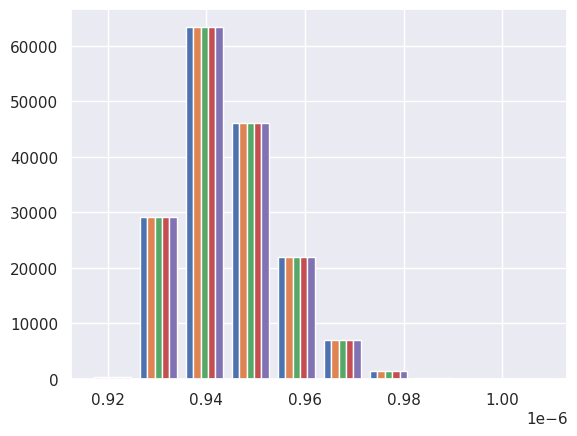

In [37]:
plt.hist(v[:,0:5])

In [24]:
v[1]

array([9.40604654e-07, 9.40604654e-07, 9.40604654e-07, 9.40604654e-07,
       9.40604654e-07])

In [25]:
v[0]

array([9.4539972e-07, 9.4539972e-07, 9.4539972e-07, 9.4539972e-07,
       9.4539972e-07])

In [26]:
v[0:,1] - v[0:,2]

array([0., 0., 0., ..., 0., 0., 0.])

In [27]:
v[0:,2]

array([9.45399720e-07, 9.40604654e-07, 9.48173762e-07, ...,
       9.35007760e-07, 9.69180016e-07, 9.45358380e-07])

In [28]:
v[0:,1]

array([9.45399720e-07, 9.40604654e-07, 9.48173762e-07, ...,
       9.35007760e-07, 9.69180016e-07, 9.45358380e-07])

In [31]:
v_init[:,0:4]

array([[ 0.02395988,  3.30472198,  1.29682956, -0.18153983],
       [ 0.00663773,  0.24586671,  0.25057694, -1.80023724],
       [ 1.14995145, -1.71105614,  0.99918648, -0.76543626],
       ...,
       [ 0.49345767, -0.6418192 , -2.16265547, -1.10450937],
       [-1.00924109, -1.05887815, -0.83319045, -0.21701763],
       [-0.94262129, -0.59652547, -0.90329545,  1.10504525]])

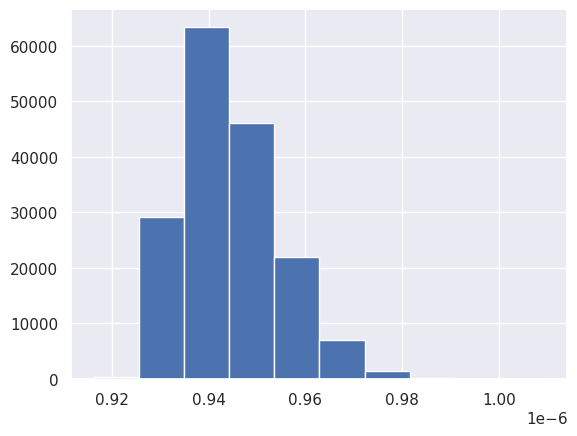

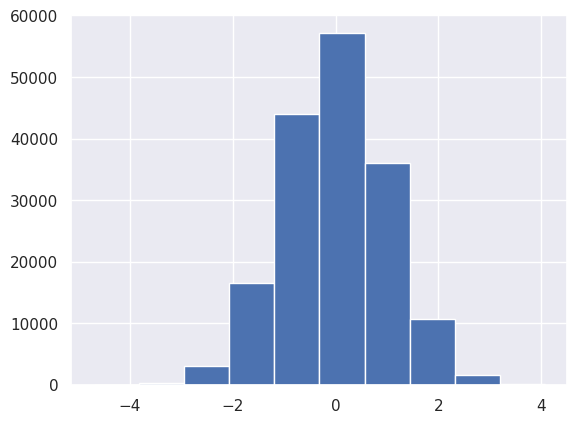

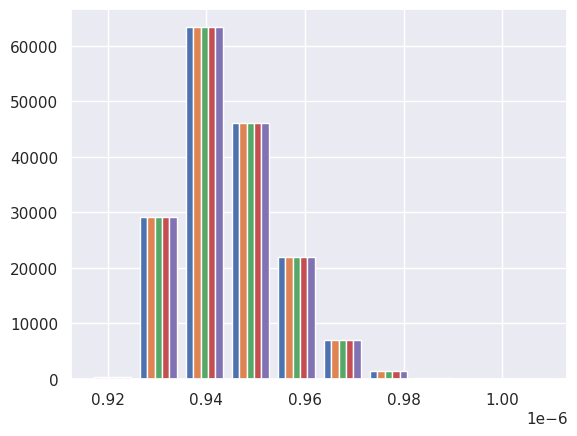

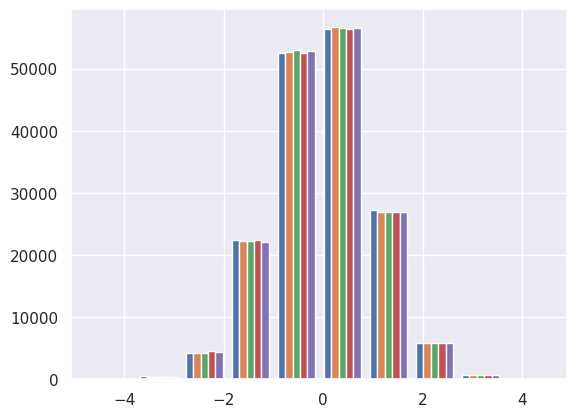

In [30]:
plt.hist((v[:,0]))
plt.show()
plt.hist((v_init[:,0]))
plt.show()

plt.hist((v))
plt.show()
plt.hist((v_init))
plt.show()

In [278]:
np.maximum(v, 0)

array([[1.26012496, 1.26012496, 1.26012496, 1.26012496, 1.26012496],
       [1.22972209, 1.22972209, 1.22972209, 1.22972209, 1.22972209],
       [1.33286021, 1.33286021, 1.33286021, 1.33286021, 1.33286021],
       ...,
       [1.17072419, 1.17072419, 1.17072419, 1.17072419, 1.17072419],
       [1.59046638, 1.59046638, 1.59046638, 1.59046638, 1.59046638],
       [1.34573175, 1.34573175, 1.34573175, 1.34573175, 1.34573175]])

In [35]:
# Attempt to learn pagerank as a multidimensional vector space

from collections import Counter
import pymc3 as pm
import theano.tensor as tt

sampling_rate=0.1
model_params['straify_sampling'] = False
iterations=1
representation_priority = 0.9
equal_allocation=False
replace = True
weight_penalty='laplacian_SGD_pagerank'
pl_label_entropy=False
resample_clones=False
n_hops=2
apply_gaussian_smoothing = False
gamma_learn = 50

kwargs = model_params

if kwargs:
    for key, value in kwargs.items():
        globals()[key] = value
    kwargs.update(locals())

    # Unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())
        
    # Initialize the size of the matrix
    N = M.shape[1]
    
    # Apply Gaussian smoothing if enabled
    if apply_gaussian_smoothing:
        print("Applying Gaussian smoothing to input connectivity matrix")
        gaussian_kernel_std = 1
        M = gaussian_smoothing(M, gaussian_kernel_std)
    
    # Initialize PageRank vector with random values and normalize
    if init_vect is None:
        print("No pre-rank vector provided, proceeding with randomised intialisation")
        v = np.random.rand(N, 1)
        v = v / np.linalg.norm(v, 1)
    else:
        print("Pre-initialised vector provided")
        v = init_vect
    
    # Initialize last PageRank vector to infinity for convergence checks
    last_v = np.ones((N, 1)) * np.inf
    
    # Dictionary to store L2 norms for each iteration
    l2_dic = {}
    
    # Set to keep track of visited nodes (for cyclic sampling)
    visited_nodes = set()
    
    # Initialize counters and lists for plateau and dip detection
    plateau_count = 0
    dips_detected = 0
    dip_positions = []

    # Initialize an array to keep track of node visit counts (for probability-based sampling)
    visited_counts = np.zeros(N)

    for iter_ in range(num_iterations):
        
        # Add variable which only starts learning rate decay after gamma time
        if iter_ <= gamma_learn:
            learning_rate = 1
            
        else:
            # Decay the learning rate to ensure convergence
            learning_rate = initial_learning_rate / ((1 + iter_)/10)
        
        # Probability-based sampling
        if sampling_method == 'probability_based':
            probabilities = 1 / (1 + visited_counts)
            probabilities /= probabilities.sum()
            mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False, p=probabilities)
        
        # Cyclic sampling
        elif sampling_method == 'cyclic':
            if len(visited_nodes) < N:
                remaining_nodes = list(set(range(N)) - visited_nodes)
                mini_batch_indices = np.random.choice(remaining_nodes, size=min(mini_batch_size, len(remaining_nodes)), replace=False)
            else:
                mini_batch_indices = np.random.choice(N, size=mini_batch_size, replace=False)
            
            # Update the set of visited nodes
            visited_nodes.update(mini_batch_indices)
        
        # Update node visit counts
        visited_counts[mini_batch_indices] += 1
        
        # Extract the mini-batch from the matrix and the PageRank vector
        M_mini_batch = M[mini_batch_indices, :]
        v_mini_batch = v[mini_batch_indices]
        
        # Store the current PageRank values for convergence checks
        last_v = v_mini_batch
        
        # Update the PageRank values using the mini-batch
        v_mini_batch = d * (learning_rate * M_mini_batch @ v) + ((1 - d) / N)
        v[mini_batch_indices] = v_mini_batch
        
        # Compute and store the L2 norm of the difference between the current and last PageRank values
        if iter_ == gamma_learn:
            l2_dic[iter_] = l2_dic[iter_ - 1] # Discount L2 norm at point of learning rate initialisation
        else:
            l2_norm = np.linalg.norm(v_mini_batch - last_v)
            l2_dic[iter_] = l2_norm
        
        # Compute smoothed L2 norms for dip detection
        if iter_ > dip_window:
            smoothed_values = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
            gradient = smoothed_values[-1] - smoothed_values[-2]
            
            # Detect dips in the smoothed L2 norms
            if gradient < -1.5 * np.std(smoothed_values):
                dips_detected += 1
                dip_positions.append(iter_)

        # Check for convergence
        if l2_norm < tolerance:
            print('Converged at iteration {}'.format(iter_))
            break
        
        # Early stopping based on smoothed L2 norms
        gradient_variance_window = 10
        if iter_ > gradient_variance_window:
            gradient_values = np.diff(smoothed_values)
            variance_of_gradient = np.var(gradient_values[-gradient_variance_window:])
            
            if sampling_method == 'probability_based' and dips_detected == 1:
                if abs(gradient_values[-1]) < 0.3 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            elif sampling_method == 'cyclic' and dips_detected > 1:
                if abs(gradient) < 0.5 * variance_of_gradient:
                    plateau_count += 1
                else:
                    plateau_count = 0

            # If the gradient has been stable for a number of iterations, stop early
            if plateau_count >= plateau_iterations:
                print(f'Early stopping at iteration {iter_} due to plateau in L2 norm changes.')
                break

    # If the algorithm hasn't converged in the given number of iterations, display a message
    if iter_ == num_iterations-1:
        print('pagerank model did not converge during the mini-batch phase')
    
    # Refine the PageRank values using full-batch updates
    print("Proceeding on to perform fine-tuning across full-batch")
    for _ in range(full_batch_update_iters):
        # Decay the learning rate to ensure convergence
        learning_rate = initial_learning_rate / ((1 + _)/10)
        last_v_global = v.copy()
        v = d * (learning_rate* M @ v) + ((1 - d) / N)
        if _ == 0:
            l2_dic[iter_ + _ + 1] = l2_dic[iter_]# Discount L2 norm at point of global initialisation
        else:
            l2_norm_global = np.linalg.norm(v - last_v_global)
            l2_dic[iter_ + _ + 1] = l2_norm_global
    
    # Plot the L2 norms, smoothed L2 norms, dips, and detected plateaus
    plt.figure(figsize=(10,6))
    plt.plot(list(l2_dic.keys()), list(l2_dic.values()), label="Original L2 Norm")
    smoothed_l2 = np.convolve(list(l2_dic.values()), np.ones(dip_window)/dip_window, mode='valid')
    plt.plot(range(dip_window - 1, dip_window - 1 + len(smoothed_l2)), smoothed_l2, 'r-', label="Smoothed L2 Norm")
    
#     for dip in dip_positions:
#         plt.axvline(x=dip, color='g', linestyle='--', label="Dip positions")
    plt.axvline(x=gamma_learn, color='g', linestyle='--', label="Learning rate decay intialisation")
    
    if plateau_count >= plateau_iterations:
        plt.axvspan(iter_ - plateau_count + 1, iter_, color='yellow', alpha=0.2, label="Detected Plateau")

    # Highlight the global fine-tuning iterations
    plt.axvspan(iter_ + 1, iter_ + full_batch_update_iters + 1, color='blue', alpha=0.1, label="Global Fine-Tuning Iterations")

    plt.yscale("log")
    plt.xlabel('Iteration')
    plt.ylabel('L2 Norm')
    plt.title('Convergence of PageRank')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if sampling_method == 'probability_based':
        print("You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data")
        print("Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement")
    elif sampling_method == 'cyclic':
        print("You should observe two dips in the graph, the first post initialisation and the second when the model starts to learn some structure and making informed updates")
        print("Erratic behavious post this second dip should trend downwards. This shows that dispite having visited all nodes and thus oscillating, we still see gradual model improvement")
    

No pre-rank vector provided, proceeding with randomised intialisation


NameError: name 'd' is not defined

# perhaps we only need to apply a gaussian smoothing kernel prior to aggregation
- Helps us scle the weights for aggregation based on the density of the region
- 

In [58]:
i_mat = neighborhood_matrix
i_mat[i_mat>0]= 1

In [67]:
i_mat.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [69]:
i_mat.sum(axis = 1).mean()

31.259443

In [74]:
plt.hist(i_mat.sum(axis = 0),bins=50)


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f05224c15e0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f05a55a3670> (for post_execute):



KeyboardInterrupt



In [47]:
csr_matrix

<169494x169494 sparse matrix of type '<class 'numpy.float32'>'
	with 5298288 stored elements in Compressed Sparse Row format>

In [42]:
attention_scores

array([[3.38912611],
       [3.3232598 ],
       [3.7562098 ],
       ...,
       [3.09757863],
       [4.68058232],
       [3.88919855]])

In [43]:
# Function to perform Gaussian smoothing on a sparse matrix
def gaussian_smoothing(M, std):
    from scipy.sparse import csr_matrix
    """
    Apply Gaussian smoothing to a sparse matrix.

    Parameters:
    - M (scipy.sparse.csr_matrix): The input sparse matrix.
    - std (float): Standard deviation of the Gaussian kernel.

    Returns:
    - scipy.sparse.csr_matrix: The smoothed matrix.
    """
    
#     # Ensure the input matrix is in CSR format
#     if not isinstance(M, csr_matrix):
#         M = csr_matrix(M)
        
#     # Get the number of rows (nodes) in the matrix
#     N = M.shape[0]

    # Create a Gaussian kernel function
    def gaussian_kernel(d, std):
        return np.exp(-d**2 / (2 * std**2))

    ## Create a Gaussian kernel as a vectorized function
    #gaussian_kernel = np.vectorize(lambda d: np.exp(-d**2 / (2 * std**2)))

    ## Apply the Gaussian kernel to all non-zero elements of the matrix
    #M.data = gaussian_kernel(M.data)

    M.data = gaussian_kernel(M.data, std)
    
    return M
    

In [44]:
gaussian_smoothing(csr_matrix, 1)

<169494x169494 sparse matrix of type '<class 'numpy.float32'>'
	with 5298288 stored elements in Compressed Sparse Row format>

In [6]:
# Function to perform Gaussian smoothing on a sparse matrix
def gaussian_smoothing(M, std):
    from scipy.sparse import csr_matrix
    """
    Apply Gaussian smoothing to a sparse matrix.

    Parameters:
    - M (scipy.sparse.csr_matrix): The input sparse matrix.
    - std (float): Standard deviation of the Gaussian kernel.

    Returns:
    - scipy.sparse.csr_matrix: The smoothed matrix.
    """
    
#     # Ensure the input matrix is in CSR format
#     if not isinstance(M, csr_matrix):
#         M = csr_matrix(M)
        
#     # Get the number of rows (nodes) in the matrix
#     N = M.shape[0]

    # Create a Gaussian kernel function
    def gaussian_kernel(d, std):
        return np.exp(-d**2 / (2 * std**2))

    ## Create a Gaussian kernel as a vectorized function
    #gaussian_kernel = np.vectorize(lambda d: np.exp(-d**2 / (2 * std**2)))

    ## Apply the Gaussian kernel to all non-zero elements of the matrix
    #M.data = gaussian_kernel(M.data)

    M.data = gaussian_kernel(M.data, std)
    
    return M

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]
apply_gaussian_smoothing = True

if apply_gaussian_smoothing:
    print("Applying Gaussian smoothing to input connectivity matrix")
    gaussian_kernel_std = 1
    neighborhood_matrix = (gaussian_smoothing(neighborhood_matrix, gaussian_kernel_std))

if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()

Applying Gaussian smoothing to input connectivity matrix
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank


0.9994537
[[0.        0.        0.        ... 0.        0.        0.9994537]]
0.00014551997


(array([1.69468e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00, 2.20000e+01]),
 array([0.        , 0.09994537, 0.19989075, 0.29983613, 0.3997815 ,
        0.49972686, 0.59967226, 0.69961762, 0.79956299, 0.89950836,
        0.99945372]),
 <BarContainer object of 10 artists>)

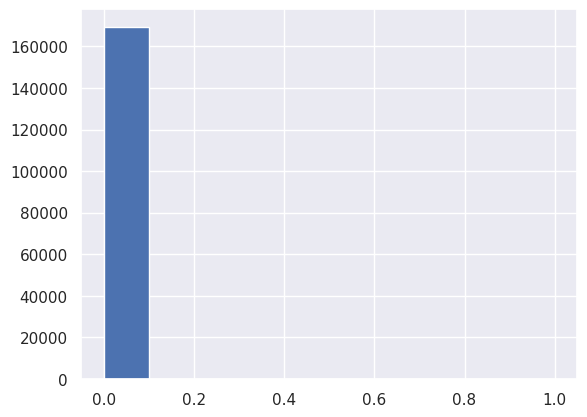

In [13]:
plt.hist(neighborhood_matrix[:,1].todense())

In [17]:
print(np.max(neighborhood_matrix[:,1].todense()))
print(np.mean(neighborhood_matrix[:,1].todense()))
print(np.std(neighborhood_matrix[:,1].todense()))

0.9994537
0.00014551997
0.011793025


(array([1.69465e+05, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 2.50000e+01]),
 array([0.        , 0.09988979, 0.19977957, 0.29966936, 0.39955914,
        0.49944893, 0.59933871, 0.69922853, 0.79911828, 0.89900804,
        0.99889785]),
 <BarContainer object of 10 artists>)

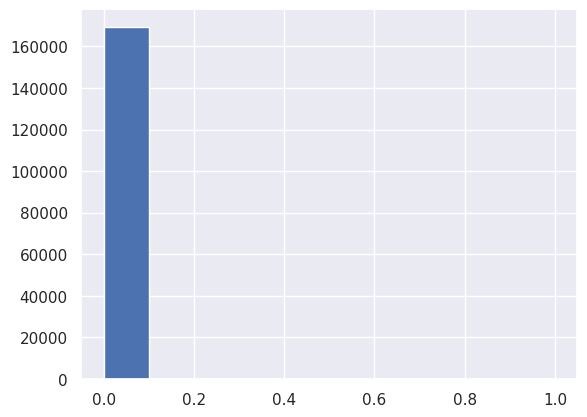

In [11]:
plt.hist(neighborhood_matrix[:,100].todense())

In [56]:
neighborhood_matrix

array([0.7080886 , 0.7786165 , 0.7407571 , ..., 0.707622  , 0.7101525 ,
       0.70994216], dtype=float32)

In [53]:
adata.obsp[adata.uns[knn_key]['connectivities_key']]

<169494x169494 sparse matrix of type '<class 'numpy.float32'>'
	with 5298288 stored elements in Compressed Sparse Row format>

In [44]:
csr_matrix

<169494x169494 sparse matrix of type '<class 'numpy.float32'>'
	with 5298288 stored elements in Compressed Sparse Row format>

# Simple measure if all cells are connected to minimum 1 pseudocell

- Set anchor states as selected pseudocells
- All cells must be connected to a minimum of alpha pseudostates
- Neighborhood hop performed dynamically


### Workflow:
- Compute naive sampling with attention scores
- Iteratively expand neighborhod until they meet a minimum alpha
- Recompute updated pagerank chunk
- Re-sample and test for connectivity.


### potential updates
- Create a vertice loss and rank distribution metric?? 

# Update 0.2.1

- Matrix regularisation:
    - Apply a gaussian kernel on the dynamic hop matrix
- Create mt Mask set which masks all cells in the derived matrix except sampled cells and missing cells
- This encourage

In [169]:
from multiprocessing import cpu_count, Pool
from tqdm import tqdm

def parallel_update(chunk_data):
    """
    Function to be used in parallel processing for updating matrix.
    """
    KNN_main_chunk, latest_updates, chunk_indices = chunk_data
    for idx in chunk_indices:
        KNN_main_chunk[idx, :] = latest_updates[idx]
    return KNN_main_chunk

def update_connectivity_matrix_in_chunks_parallel(KNN_main, updates_dict, chunk_size=1000):
    """
    Updates the connectivity matrix in chunks for memory efficiency.
    
    Args:
    - KNN_main: The main connectivity matrix.
    - updates_dict: Dictionary containing updates for each epoch.
    - chunk_size: Size of each chunk for updating the matrix.

    Returns:
    An updated connectivity matrix.
    """
    # Determine the latest epoch for each vertex
    latest_updates = {}
    for epoch, (indices, KNN_hop) in updates_dict.items():
        for idx, original_idx in enumerate(indices):
            latest_updates[original_idx] = KNN_hop[idx, :]

    all_indices = sorted(list(latest_updates.keys()))
    total_indices = len(all_indices)

    # Check if parallel processing is possible
    num_cpus = cpu_count()

    if num_cpus > 1:
        with Pool(processes=num_cpus) as pool:
            chunk_data = [(KNN_main.copy(), latest_updates, all_indices[i:i+chunk_size]) 
                          for i in range(0, total_indices, chunk_size)]
            
            results = list(tqdm(pool.imap(parallel_update, chunk_data), total=len(chunk_data)))
            for i, updated_chunk in enumerate(results):
                start_idx = i * chunk_size
                end_idx = start_idx + chunk_size
                KNN_main[start_idx:end_idx, :] = updated_chunk[start_idx:end_idx, :]
    else:
        # Update the main matrix in chunks without parallel processing
        for i in tqdm(range(0, total_indices, chunk_size)):
            chunk_indices = all_indices[i:i+chunk_size]
            for idx in chunk_indices:
                KNN_main[idx, :] = latest_updates[idx]
    
    # Ensure the matrix is symmetrical
    KNN_main = (KNN_main + KNN_main.transpose()).tocsr()
    KNN_main.data = np.where(KNN_main.data > 0, 1, 0)

    return KNN_main

def update_connectivity_matrix_in_chunks(KNN_main, updates_dict, chunk_size=1000):
    """
    Updates the connectivity matrix in chunks for memory efficiency with a progress bar.
    
    Args:
    - KNN_main: The main connectivity matrix.
    - updates_dict: Dictionary containing updates for each epoch.
    - chunk_size: Size of each chunk for updating the matrix.

    Returns:
    An updated connectivity matrix.
    """
    print("Updating connectivity matrix in chunks")
    # Determine the latest epoch for each vertex
    latest_updates = {}
    for epoch, (indices, KNN_hop) in updates_dict.items():
        for idx, original_idx in enumerate(indices):
            latest_updates[original_idx] = KNN_hop[idx, :]

    all_indices = sorted(list(latest_updates.keys()))
    total_indices = len(all_indices)

    # Update the main matrix in chunks with tqdm progress bar
    for i in tqdm(range(0, total_indices, chunk_size), total=len(range(0, total_indices, chunk_size))):
        chunk_indices = all_indices[i:i+chunk_size]
        for idx in chunk_indices:
            KNN_main[idx, :] = latest_updates[idx]
    
    # Ensure the matrix is symmetrical
    KNN_main = (KNN_main + KNN_main.transpose()).tocsr()
    KNN_main.data = np.where(KNN_main.data > 0, 1, 0)

    return KNN_main


# Update the main function to use the corrected update function
def expand_neighborhoods_chunked(adata, adata_samp, param_set):
    KNN_main = adata.obsp['connectivities']
    updates_dict = {}  # Store the updates for each epoch
    results_dict = {}  # Final results dictionary
    
    epoch = 0
    hop_v_indices = [1]  # Initialize with a non-empty list to start the loop.
    samp_indices = np.where(adata.obs.index.isin(adata_samp.obs.index))[0]

    while epoch <= param_set['epoch'] and len(hop_v_indices) > 0:
        print(f"Epoch: {epoch}")
        
        # Extract submatrix based on sampled data
        KNN_tmp = KNN_main[adata.obs.index.isin(adata_samp.obs.index)]
        KNN_tmp.data = np.where(KNN_tmp.data > 0, 1, 0)

        # Find indices not connected to any sampled node
        if epoch == 0:
            indices = np.where(KNN_tmp.sum(axis=0) <= param_set['alpha'])[1]
        else:
            indices = hop_v_indices

        KNN_hop = KNN_main[indices]
        KNN_hop = KNN_hop * KNN_main

        # Convert KNN_hop to a temporary binary neighborhood matrix
        KNN_hop_tmp = KNN_hop[:, samp_indices].copy()
        KNN_hop_tmp.data = np.where(KNN_hop_tmp.data > 0, 1, 0)
        
        hop_v_indices = np.where(KNN_hop_tmp.sum(axis=1) <= param_set['alpha'])[0]
        updates_dict[epoch] = (indices, KNN_hop)

        epoch += 1

    # Reconstruct the main matrix using the chunked update function
    KNN_updated = update_connectivity_matrix_in_chunks(KNN_main, updates_dict)
    
    results_dict["main_matrix"] = KNN_updated
    results_dict["updates"] = updates_dict

    return results_dict

# results = expand_neighborhoods_chunked_corrected(adata, adata_samp, param_set)



In [170]:
from multiprocessing import cpu_count, Pool
from tqdm import tqdm
import scipy.sparse as sp

def parallel_update(args):
    """
    Function to update specific rows of the KNN matrix in parallel.
    """
    KNN_main, latest_updates, chunk_indices = args
    rows_to_update = sp.vstack([latest_updates[idx] for idx in chunk_indices])
    KNN_main[chunk_indices, :] = rows_to_update
    return KNN_main

# def update_connectivity_matrix_in_chunks_parallel(KNN_main, updates_dict, chunk_size=1000):
#     """
#     Updates the connectivity matrix in chunks for memory efficiency.
#     """
#     # Flatten the updates into a single matrix for efficient access
#     latest_updates = sp.vstack([updates_dict[epoch][1] for epoch in sorted(updates_dict.keys())])

#     all_indices = sorted(list(set(idx for epoch, (indices, _) in updates_dict.items() for idx in indices)))
#     total_indices = len(all_indices)

#     num_cpus = cpu_count()

#     if num_cpus > 1:
#         # Parallel processing
#         with Pool(processes=num_cpus) as pool:
#             chunk_data = [(KNN_main, latest_updates, all_indices[i:i + chunk_size]) for i in range(0, total_indices, chunk_size)]
#             results = list(tqdm(pool.imap(parallel_update, chunk_data), total=len(chunk_data)))

#             # Combine the results
#             KNN_main = sp.vstack(results)
#     else:
#         # Sequential processing
#         for i in tqdm(range(0, total_indices, chunk_size)):
#             chunk_indices = all_indices[i:i + chunk_size]
#             rows_to_update = sp.vstack([latest_updates[idx] for idx in chunk_indices])
#             KNN_main[chunk_indices, :] = rows_to_update

#     # Ensure the matrix is symmetrical
#     KNN_main = (KNN_main + KNN_main.transpose()).tocsr()
#     KNN_main.data = np.where(KNN_main.data > 0, 1, 0)

#     return KNN_main

# Update the main function to use the corrected update function
def expand_neighborhoods_chunked(adata, adata_samp, param_set):
    KNN_main = adata.obsp['connectivities']
    updates_dict = {}  # Store the updates for each epoch
    results_dict = {}  # Final results dictionary
    
    epoch = 0
    hop_v_indices = [1]  # Initialize with a non-empty list to start the loop.
    samp_indices = np.where(adata.obs.index.isin(adata_samp.obs.index))[0]

    while epoch <= param_set['epoch'] and len(hop_v_indices) > 0:
        print(f"Epoch: {epoch}")
        
        # Extract submatrix based on sampled data
        KNN_tmp = KNN_main[adata.obs.index.isin(adata_samp.obs.index)]
        KNN_tmp.data = np.where(KNN_tmp.data > 0, 1, 0)

        # Find indices not connected to any sampled node
        if epoch == 0:
            indices = np.where(KNN_tmp.sum(axis=0) <= param_set['alpha'])[1]
        else:
            indices = hop_v_indices

        KNN_hop = KNN_main[indices]
        KNN_hop = KNN_hop * KNN_main

        # Convert KNN_hop to a temporary binary neighborhood matrix
        KNN_hop_tmp = KNN_hop[:, samp_indices].copy()
        KNN_hop_tmp.data = np.where(KNN_hop_tmp.data > 0, 1, 0)
        
        hop_v_indices = np.where(KNN_hop_tmp.sum(axis=1) <= param_set['alpha'])[0]
        updates_dict[epoch] = (indices, KNN_hop)

        epoch += 1

    # Reconstruct the main matrix using the chunked update function
    KNN_updated = update_connectivity_matrix_in_chunks(KNN_main, updates_dict)
    
    results_dict["main_matrix"] = KNN_updated
    results_dict["updates"] = updates_dict

    return results_dict

In [171]:
param_set = {
'epoch' : 5,
'alpha':0,  
}
results = expand_neighborhoods_chunked(adata, adata_samp, param_set)

Epoch: 0
Updating connectivity matrix in chunks


100%|██████████| 11/11 [10:43<00:00, 58.47s/it]


In [ ]:
KNN_sp = KNN_s*KNN_main
KNN_sp[KNN_sp>0] = 1
sp_v_indices = np.where(KNN_sp.sum(axis=0) <= param_set['alpha'])[1]

In [247]:
#Test
update_mat = results['main_matrix']
adata.obsp[adata.uns[knn_key]['connectivities_key']] = update_mat

In [173]:
kwargs['init_vect'] = adata.obs['sf_attention'].copy()

In [248]:
# kwargs['mini_batch_size'] = 1000
# kwargs['num_iterations'] = 1000# How many mini-batches to learn
kwargs['full_batch_update_iters'] = 200 # How many full batch updates
# kwargs['initial_learning_rate']=0.85
kwargs['gamma_learn']=100

Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank
Pre-initialised vector provided
Converged at iteration 581
Proceeding on to perform fine-tuning across full-batch


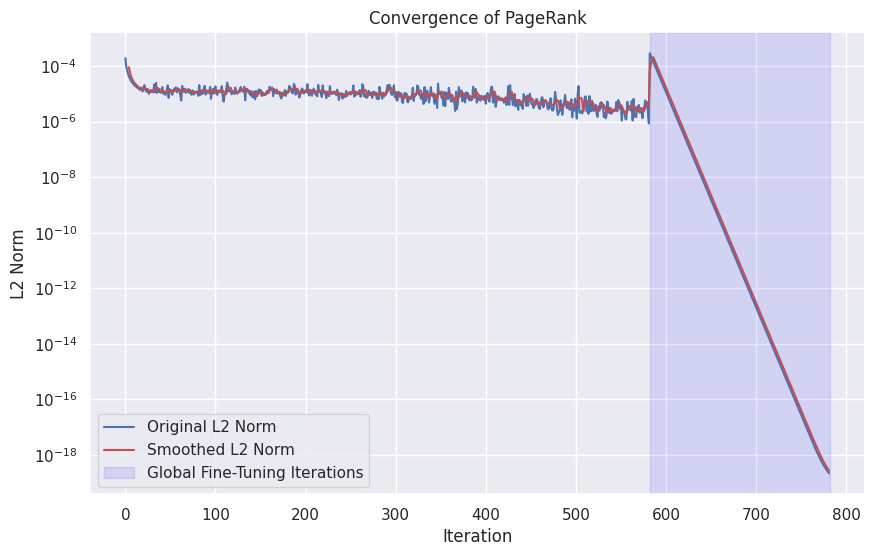

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors
Sampling complete!


array([ 3.64559216,  4.74744109,  5.1555784 , ..., 12.08460294,
        5.42907157,  4.87469769])

In [249]:
print('Non-stratified sampling based on attention weights chosen')

if representation_priority > 0.8:
    print('warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')
    warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')

neighborhood_matrix = adata.obsp[adata.uns[knn_key]['connectivities_key']]

#Experimental feature with 1 hop matrix
#neighborhood_matrix = neighborhood_matrix**n_hops ## N hops shopuld be added as an option in next iter. this controls the coverage of the graph

# Calculate total sample size and sample size per label for equal allocation
total_sample_size = int(sampling_rate * adata.shape[0])
#     sample_size_per_label = total_sample_size // len(unique_labels)

if weight_penalty == "laplacian_SGD_pagerank":# This is essentially an attention score
    print('Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank')
    # This is essentially the calculation of the Laplacian of the graph.
    # Calculate degrees
    degrees = np.array(neighborhood_matrix.sum(axis=1)).flatten() +1 # this is a generalization of the concept of degree for weighted graphs
    # Calculate inverse square root of degrees
    inv_sqrt_degrees = 1 / np.sqrt(degrees)
    # Create diagonal matrix of inverse square root degrees
    inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
    # Apply transformation to the adjacency matrix
    normalized_matrix = inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
#     # Now you can use normalized_matrix in place of neighborhood_matrix
#     attention_score = normalized_matrix[indices].sum(axis = 1)
# Convert your sparse matrix to a csr_matrix if it's not already
    csr_matrix = normalized_matrix.tocsr()
    attention_scores, l2_norm_dic = SGDpagerank(csr_matrix,  **kwargs) #num_iterations=1000,sampling_method='probability_based', mini_batch_size=1000, initial_learning_rate=0.85, tolerance=1e-6, d=0.85, full_batch_update_iters=100,

print("proceeding to 2 stage sampling using attention scores as priors")
attention_scores = attention_scores*(1*10**6)
# Add the attention scores to the observation dataframe
adata.obs['sf_attention'] = attention_scores

# Iterate over each unique stratifying variable
# for n in adata.obs[strat_var].unique():
tmp_obs = adata.obs#[adata.obs[strat_var] == n]
indices = range(len(tmp_obs))
attention_scores_tmp = tmp_obs['sf_attention']

# Apply softmax to attention scores
e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
sf_attention = e_v / e_v.sum()

# Calculate total sample size
total_sample_size = int(sampling_rate * len(tmp_obs))

# Initialize list to store all sampled indices
all_sampled_indices = []

# Conduct sampling N times (100 by default)
N = 100
for i in range(N):
    sampled_indices = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)
    all_sampled_indices.extend(sampled_indices)

# Count the frequency of each index
index_freq = Counter(all_sampled_indices)

# Convert the frequencies to probabilities
total_samples = sum(index_freq.values())
sampling_probabilities = {index: freq / total_samples for index, freq in index_freq.items()}

# Convert dictionary keys and values to lists for sampling
sample_indices = list(sampling_probabilities.keys())
sample_probs = list(sampling_probabilities.values())

sampled_indices_from_output = np.random.choice(sample_indices, size=total_sample_size, p=sample_probs, replace=False)

adata_samp = adata[sampled_indices_from_output]
print("Sampling complete!")


adata_samp
sampling_probabilities
attention_scores

In [250]:
sampled_indices = np.random.choice(indices, size=total_sample_size, replace=False, p=sf_attention)
test = adata[sampled_indices]
set(test.obs['LVL3']) ^ set(adata.obs['LVL3'])

{'CMP', 'MONO MAC DC2', 'NK', 'PROMONOCYTE', 'unassigned_HSPC_2'}

In [251]:
init_vect = attention_scores

In [252]:
if init_vect is None:
    print('none')

In [14]:
attention_scores

array([[9.45399720e-07],
       [9.40604654e-07],
       [9.48173762e-07],
       ...,
       [9.35007760e-07],
       [9.69180016e-07],
       [9.45358380e-07]])

In [15]:
# attention_scores = attention_scores*(1*10**6)
weights = attention_scores

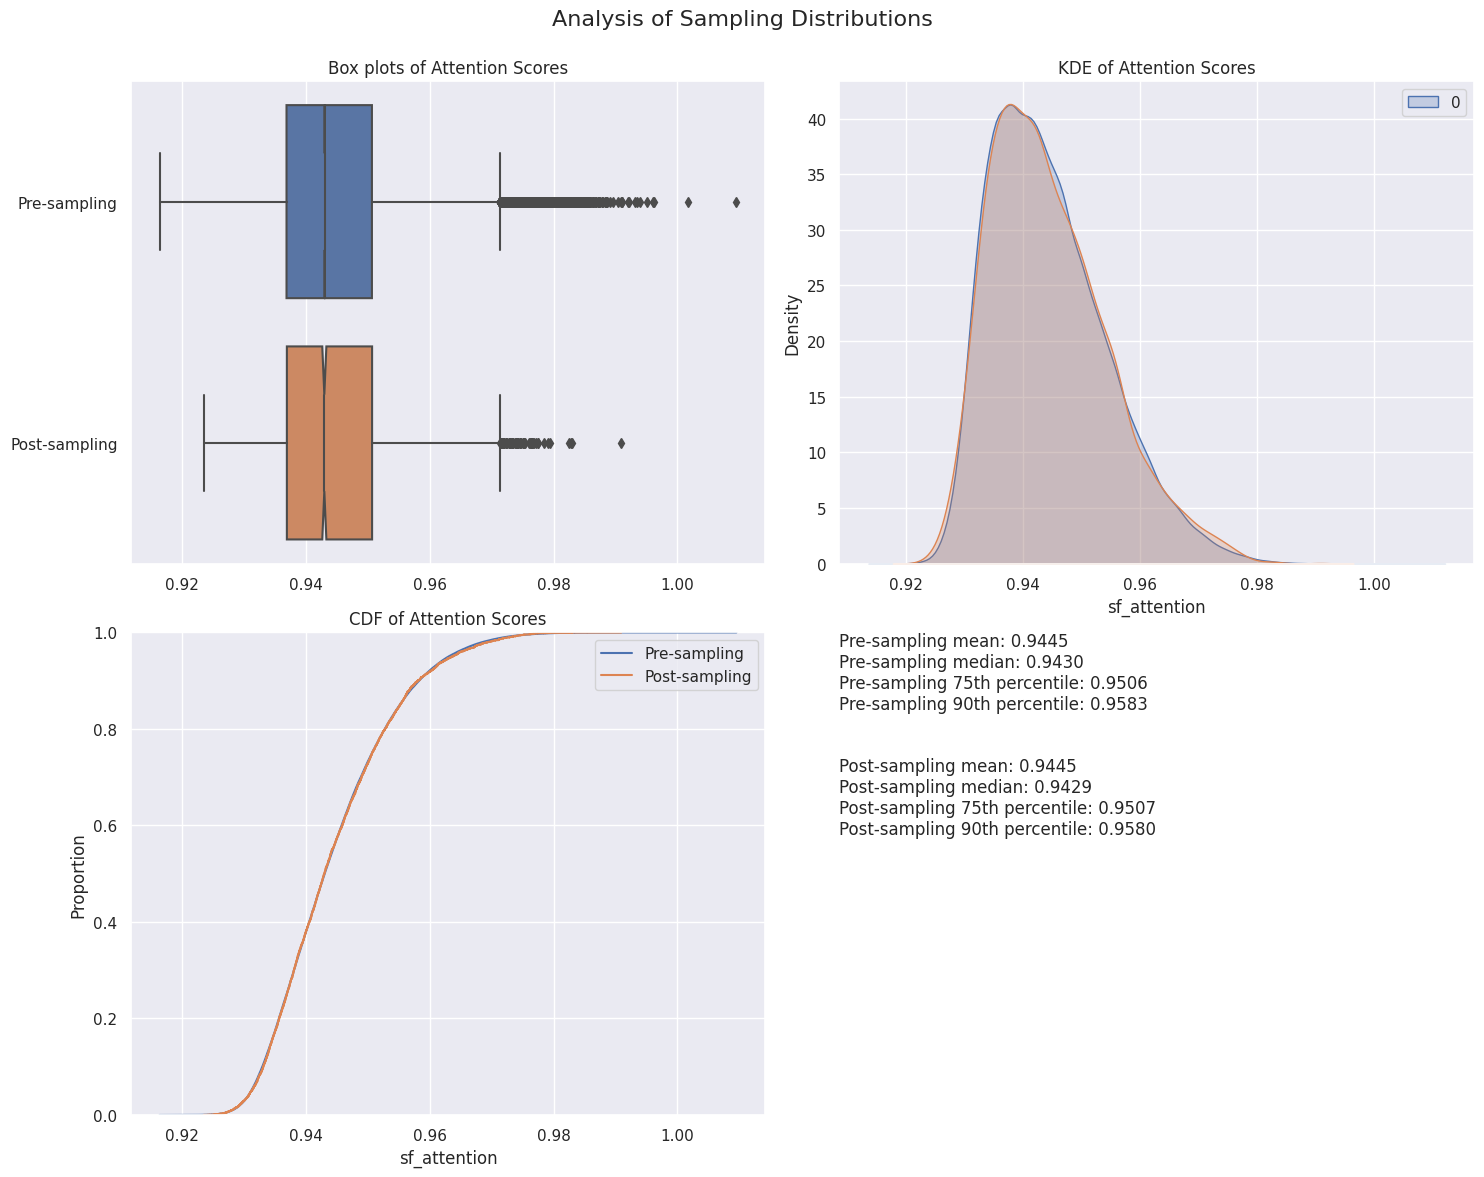

In [16]:
# Extract attention scores
# obs  = adata.obs.copy()
# obs['sf_attention'] = 0
# obs = obs.iloc[weights['all_indices']]
# obs['sf_attention'] = weights['all_weights']
# adata_samp.obs['sf_attention'] =obs.loc[obs.index.isin(adata_samp.obs.index),'sf_attention']

pre_sample_scores = weights
post_sample_scores = adata_samp.obs['sf_attention']

scent.analyze_sampling_distribution(pre_sample_scores, post_sample_scores)

In [255]:
results

{'main_matrix': <169494x169494 sparse matrix of type '<class 'numpy.int64'>'
 	with 10477687 stored elements in Compressed Sparse Row format>,
 'updates': {0: (array([    41,     62,     65, ..., 169451, 169466, 169491]),
   <8109x169494 sparse matrix of type '<class 'numpy.float32'>'
   	with 2842149 stored elements in Compressed Sparse Row format>)}}

# Compare sampling bias against Randomised boostrap sampling distribution

In [256]:
sample_probs = sampling_probabilities

Missing categories in samp_obs: MID_ERYTHROID, MONO MAC DC2, NK


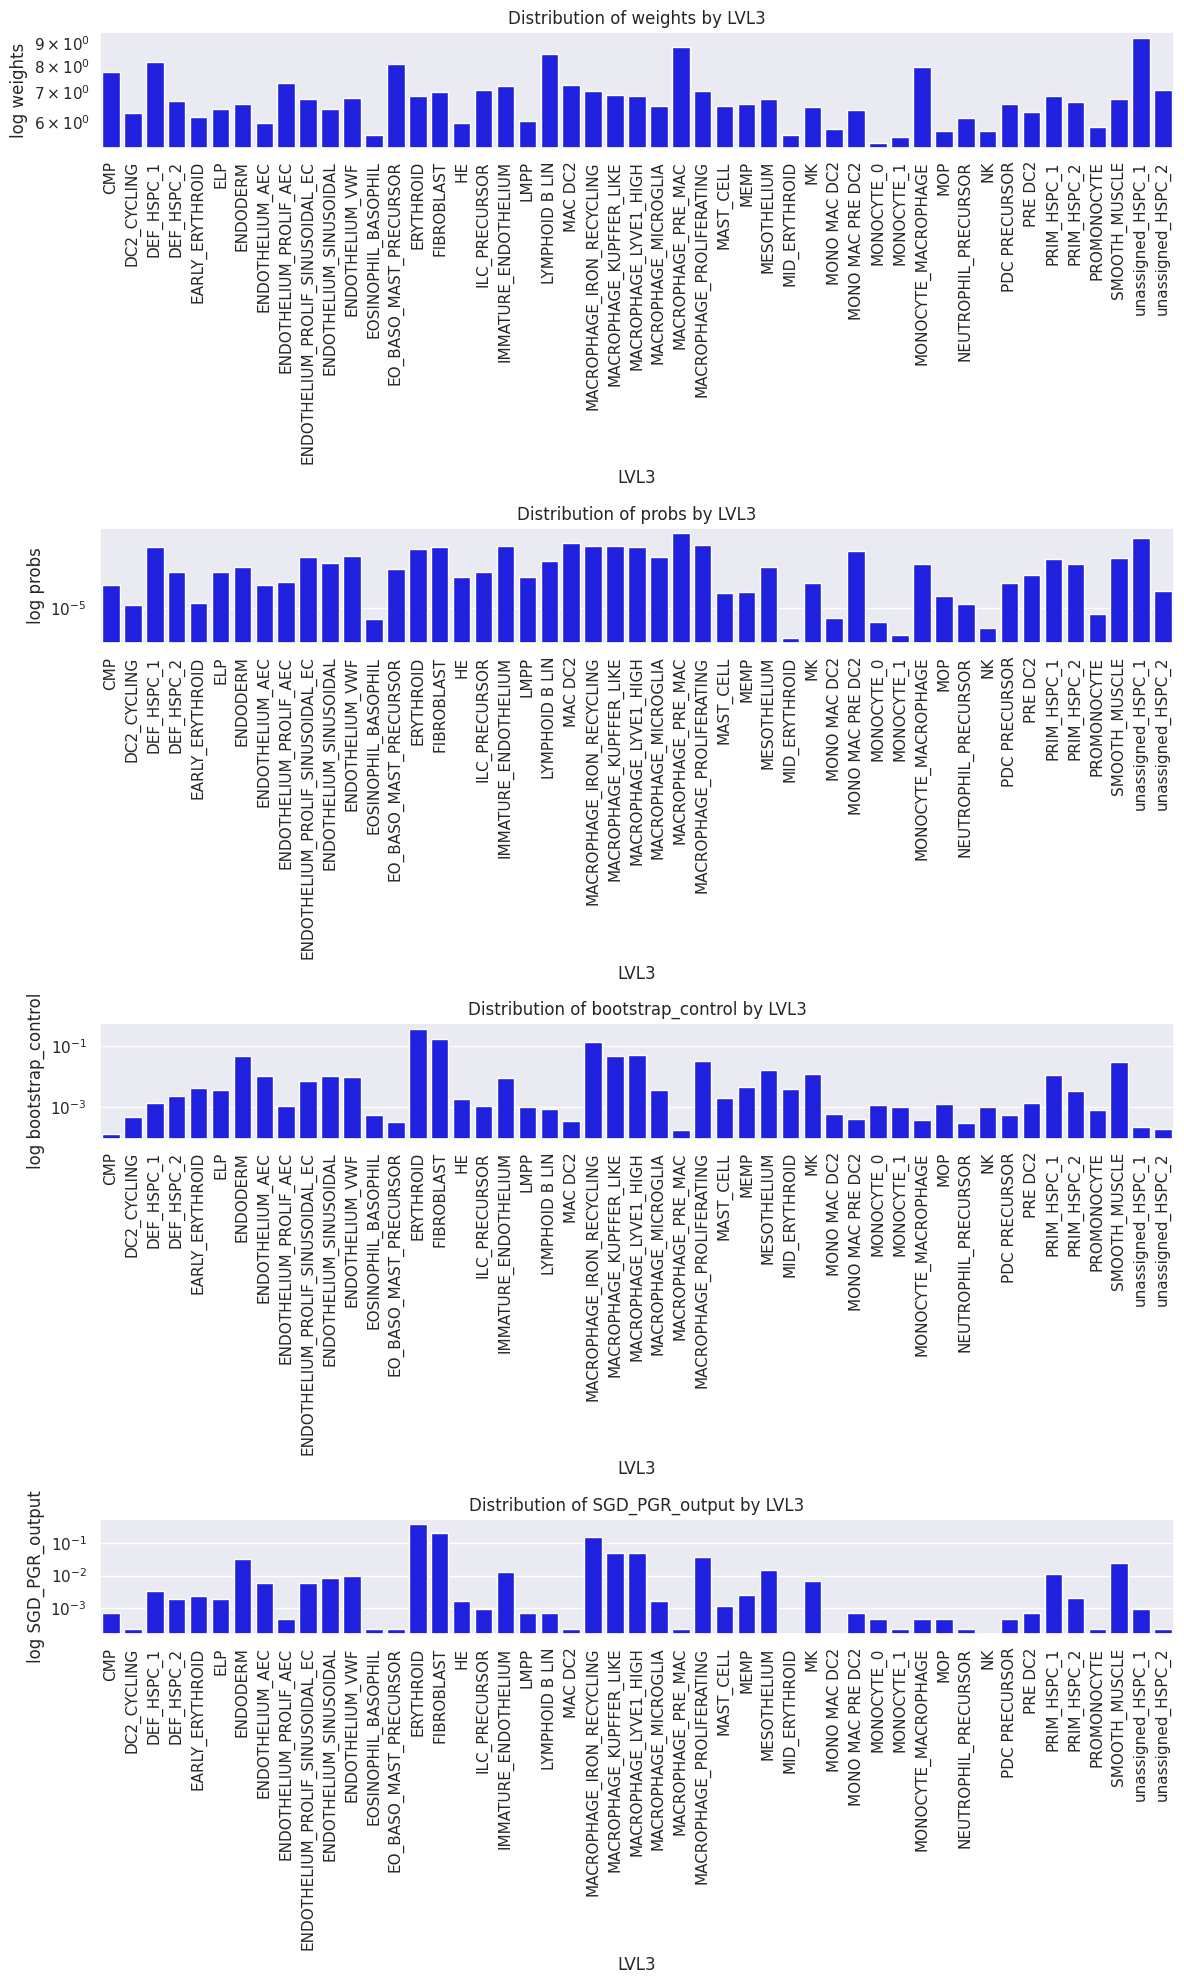

In [257]:
import seaborn as sns
def plot_grouped_distributions(df, plot_vars, grouping):
    # Initialize the figure
    fig_width = 12
    fig, axs = plt.subplots(len(plot_vars), 1, figsize=(fig_width, 5 * len(plot_vars)))
    
    # Make sure axs is always a list, even if plot_vars has only one item
    if len(plot_vars) == 1:
        axs = [axs]
    
    for idx, var in enumerate(plot_vars):
        sns.barplot(x=df.index, y=df[var], ax=axs[idx], color='blue')
        axs[idx].set_title(f'Distribution of {var} by {grouping}')
        axs[idx].set_xlabel(grouping)
        axs[idx].set_ylabel("log " + var)
        axs[idx].set_yscale("log")  # Set y-axis to log scale
        plt.setp(axs[idx].xaxis.get_majorticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.show()

def compute_sampling_probability(df, grouping, sample_fraction=0.1, n_iterations=1000):
    # Step 1: Compute original proportions
    original_counts = df.groupby(grouping).size()
    original_proportions = original_counts / len(df)
    
    sampled_proportions = {group: [] for group in original_proportions.index}
    
    # Step 2: Perform Bootstrapping
    for _ in range(n_iterations):
        sampled_df = df.sample(frac=sample_fraction)
        sampled_counts = sampled_df.groupby(grouping).size()
        for group in original_proportions.index:
            sampled_proportions[group].append(sampled_counts.get(group, 0) / len(sampled_df))
    
    # Step 3: Compute sampling proportions mean
    sampling_probabilities = {group: np.mean(proportions) for group, proportions in sampled_proportions.items()}
    
    return sampling_probabilities

# Using the function with pseudo data, since I don't have the exact obs dataframe

grouping = 'LVL3'
plot_vars = ['weights', 'probs', 'bootstrap_control', 'SGD_PGR_output']

obs = adata.obs.copy()
# Create a randomized sampling 
random_sampling_probabilities = compute_sampling_probability(obs, grouping,sample_fraction = model_params['sampling_rate'])
# Add the SGD_PGR sampled data distribution
samp_obs = adata_samp.obs.copy()
samp_obs = dict(samp_obs.groupby(grouping).size()/sum(samp_obs.groupby(grouping).size()))

obs['weights'] = weights
obs = obs.iloc[list(sample_probs.keys())]
obs['probs'] = list(sample_probs.values())
obs = obs.groupby(grouping).mean()
# Add random sampling
obs['bootstrap_control'] = [random_sampling_probabilities[group] for group in obs.index]

# Handle missing categories and add SGD_PGR sampled data
missing_categories = []
sgd_pgr_output = []

for group in obs.index:
    try:
        sgd_pgr_output.append(samp_obs[group])
    except KeyError:
        missing_categories.append(group)
        sgd_pgr_output.append(None)  # Or any default value you'd prefer, like np.nan

obs['SGD_PGR_output'] = sgd_pgr_output

if missing_categories:
    print(f"Missing categories in samp_obs: {', '.join(missing_categories)}")

plot_grouped_distributions(obs, plot_vars, grouping)

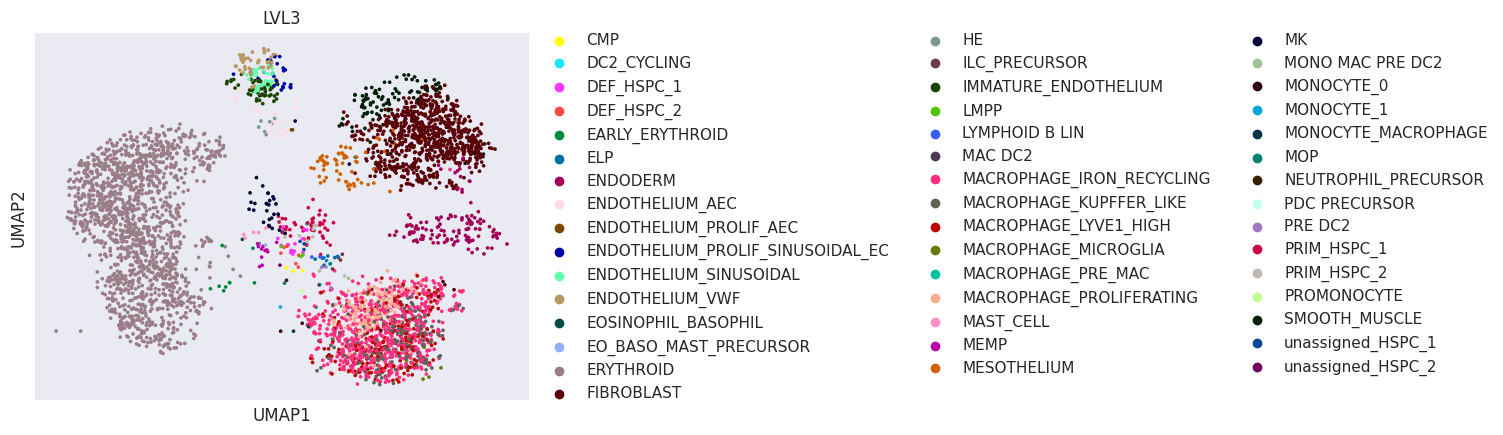

In [259]:
sc.pl.umap(adata_samp,color = 'LVL3')

In [239]:
obs

,n_genes,n_counts,sf_attention,weights,probs,bootstrap_control,SGD_PGR_output
LVL3,,,,,,,
CMP,4163.800000,24708.919922,0.911597,0.911597,0.000007,0.000158,NaN
DC2_CYCLING,4806.525641,30230.974609,0.913085,0.913085,0.000006,0.000490,0.000472
DEF_HSPC_1,3690.587156,19188.367188,0.912469,0.912469,0.000007,0.001419,0.000944
DEF_HSPC_2,4878.283708,29573.087891,0.913383,0.913383,0.000006,0.002253,0.002124
EARLY_ERYTHROID,4356.021705,33484.121094,0.914142,0.914142,0.000006,0.004068,0.004248
ELP,2785.357664,11889.251953,0.913664,0.913664,0.000006,0.003592,0.003540
ENDODERM,2043.785967,15812.867188,0.913708,0.913708,0.000006,0.045073,0.039179
ENDOTHELIUM_AEC,2757.472542,9303.078125,0.913976,0.913976,0.000006,0.010105,0.009913
ENDOTHELIUM_PROLIF_AEC,4605.101190,19988.941406,0.913155,0.913155,0.000006,0.001066,0.001180


### Methodology for Neighborhood-Based Pseudobulk Aggregation of scRNA-seq Data

#### Update ver A0.1.2 -- 
   - Updated aggregation function to detect backed readings
   - if data is backed, assume large X partition is inevitable & create chunked reads of X for updates

#### Background:
Single-cell RNA sequencing (scRNA-seq) datasets capture diverse biological states across many cells, making it computationally challenging to analyze them directly. Pseudobulk aggregation offers a way to distill this complexity by combining data from multiple cells. This method aggregates cells based on local neighborhoods, ensuring a more biologically meaningful representation. Additionally, it incorporates a normalization step inspired by the scVI model, providing a balanced representation of each cell within its local context.

#### Objective:
To generate pseudobulk gene expression profiles by aggregating cells within neighborhoods defined by a k-nearest neighbors (KNN) connectivity matrix, ensuring that each cell's contribution is fairly represented based on its local context.

#### Method:
Given a scRNA-seq dataset with $( N $) cells and $( G $) genes represented by a matrix $( X $) of dimensions $( N $times G $), and a KNN connectivity matrix $( C $) of dimensions $( N $times N $), we aim to aggregate data in neighborhoods of sampled cells to produce pseudobulk profiles.

1. **Neighborhood Definition**:
For a given sampled cell $( i $), its neighborhood is defined by the non-zero entries in row $( i $) of the KNN connectivity matrix $( C $).

$$ \text{Neighborhood}(i) = \{ j | C_{ij} > 0 \} $$

2. **Local Scaling Factors**:
For each neighborhood associated with a sampled cell \( i \), a scaling factor is computed for every cell in that neighborhood based on the cell's total counts relative to the average counts of cells within that neighborhood.

$$ \text{LocalScalingFactor}(j) = \frac{\sum_{g=1}^{G} X_{jg}}{\frac{1}{|\text{Neighborhood}(i)|} \sum_{n \in \text{Neighborhood}(i)} \sum_{g=1}^{G} X_{ng}} $$

where \( j \) is a cell in the neighborhood of sampled cell \( i \).

3. **Neighborhood Aggregation**:
For each sampled cell \( i \), the pseudobulk profile is generated by aggregating the expression data of its neighborhood cells. The aggregated expression of gene \( g \) for cell \( i \) is given by:

$$ \text{Pseudobulk}_{ig} = \frac{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j) \times X_{jg}}{\sum_{j \in \text{Neighborhood}(i)} \text{LocalScalingFactor}(j)} $$

This results in a matrix \( P \) of dimensions \( S \times G \), where \( S \) is the number of sampled cells.


#### Why account for scaling factors by total counts?

1. **Accounting for Differences in Sequencing Depth**: 
   In scRNA-seq experiments, there can be variability in the number of UMIs (Unique Molecular Identifiers) or total reads captured for each cell. This variation can arise due to technical biases, efficiency of RNA capture, or other factors. The scaling factor normalization ensures that each cell's expression profile is scaled to a common reference, which reduces the impact of this variability on downstream analyses.

2. **Fair Representation**:
   By scaling each cell's expression data with its corresponding factor, you ensure that no single cell (or group of cells with higher sequencing depth) unduly dominates the aggregated pseudobulk profile. This is especially important in neighborhood-based aggregation where you want the pseudobulk profile to be a representative summary of all cells in the neighborhood.

3. **Enhancing Biological Signal**:
   Normalizing by a scaling factor can help in emphasizing the biological variability over the technical variability. This is particularly useful when looking for differentially expressed genes or when clustering cells, as it allows for biological differences between cells or groups of cells to become more apparent.

4. **Comparability**:
   Scaling ensures that the aggregated profiles (or even individual cell profiles) from different samples, experiments, or batches can be compared directly. Without normalization, differences in sequencing depth or technical biases might confound the biological interpretations.

5. **Stabilizing Variance**:
   In many high-dimensional datasets, including scRNA-seq, the variance often scales with the mean. By normalizing using a scaling factor, this relationship can be stabilized, which can be crucial for many downstream statistical analyses.

In summary, normalizing to a scaling factor prior to aggregation is essential to ensure that the aggregated data is free from technical biases, represents all cells fairly, and highlights true biological differences. It sets a consistent baseline across cells, making the aggregated profiles more interpretable and comparable.

In [181]:
#adata_samp = adata_samp.to_memory()

# This Pseudobulk output is not batch corrected
#### output from 1 hop matrix in intitialisation

# Add a argument for forcing chunked

In [182]:
adata.isbacked

False

In [191]:
# Create pseudocells from the main data
adata_samp = adata[adata.obs.index.isin(adata_samp.obs.index)].to_memory()
connectivity_matrix = adata.obsp[adata.uns[model_params['knn_key']]['connectivities_key']]
# connectivity_matrix = connectivity_matrix**2
#connectivity_matrix = csr_matrix
pseudobulk_adata = scent.aggregate_data(adata, adata_samp, connectivity_matrix, method='local',chunk_size = 1000)

Data is small enough to proceed with direct dot products


In [192]:
pseudobulk_adata

AnnData object with n_obs × n_vars = 4237 × 37318
    obs: 'file', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean', 'celltype_annotation', 'cell.labels', 'stage', 'lanes', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2_num', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_

8.527381


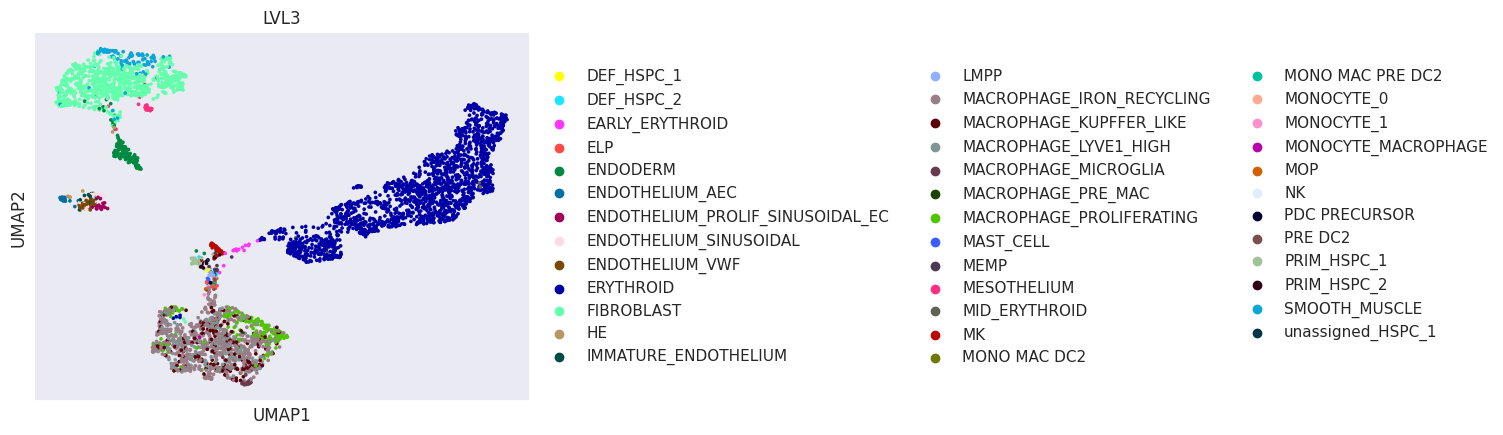

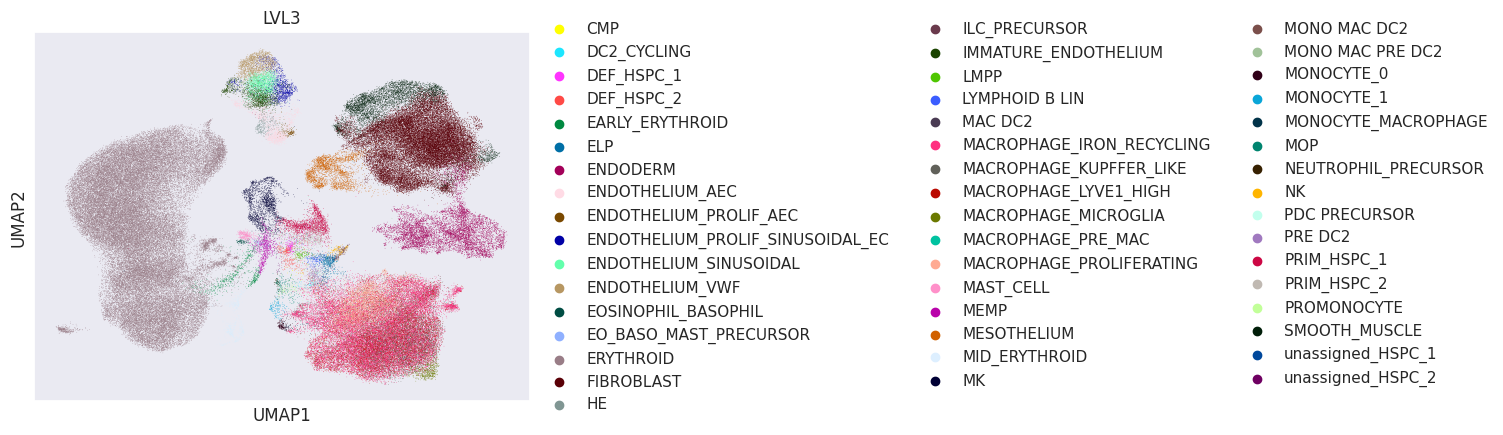

In [193]:
pseudobulk_adata_tt = pseudobulk_adata.copy()
sc.pp.normalize_per_cell(pseudobulk_adata_tt, counts_per_cell_after=1e4)
sc.pp.log1p(pseudobulk_adata_tt)
print(np.max(pseudobulk_adata_tt.X))
#pseudobulk_adata.obsm = adata_samp.obsm
sc.pp.highly_variable_genes(pseudobulk_adata_tt, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.pca(pseudobulk_adata_tt,use_highly_variable=True)
sc.pp.neighbors(pseudobulk_adata_tt, n_neighbors=30, n_pcs=30)
sc.tl.umap(pseudobulk_adata_tt)
sc.pl.umap(pseudobulk_adata_tt,color = 'LVL3')
sc.pl.umap(adata,color = 'LVL3')

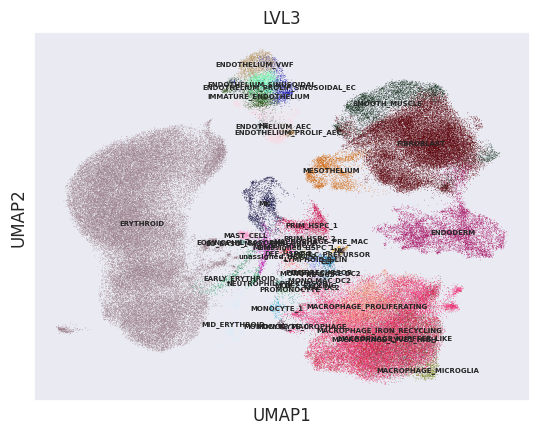

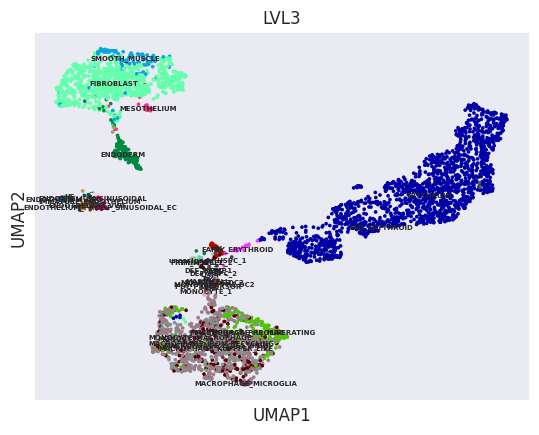

In [199]:
sc.pl.umap(adata,color = 'LVL3',legend_loc='on data',legend_fontsize = 5)
sc.pl.umap(pseudobulk_adata_tt,color = 'LVL3',legend_loc='on data',legend_fontsize = 5)

In [203]:
set(pseudobulk_adata_tt.obs['LVL3'])^ set(adata.obs['LVL3'])

{'CMP',
 'DC2_CYCLING',
 'ENDOTHELIUM_PROLIF_AEC',
 'EOSINOPHIL_BASOPHIL',
 'EO_BASO_MAST_PRECURSOR',
 'ILC_PRECURSOR',
 'LYMPHOID B LIN',
 'MAC DC2',
 'NEUTROPHIL_PRECURSOR',
 'PROMONOCYTE',
 'unassigned_HSPC_2'}

In [195]:
sc.tl.draw_graph(pseudobulk_adata_tt, layout='fa', init_pos=None, root=None, random_state=0, n_jobs=None, adjacency=None, key_added_ext=None, neighbors_key=None, obsp=None, copy=False)

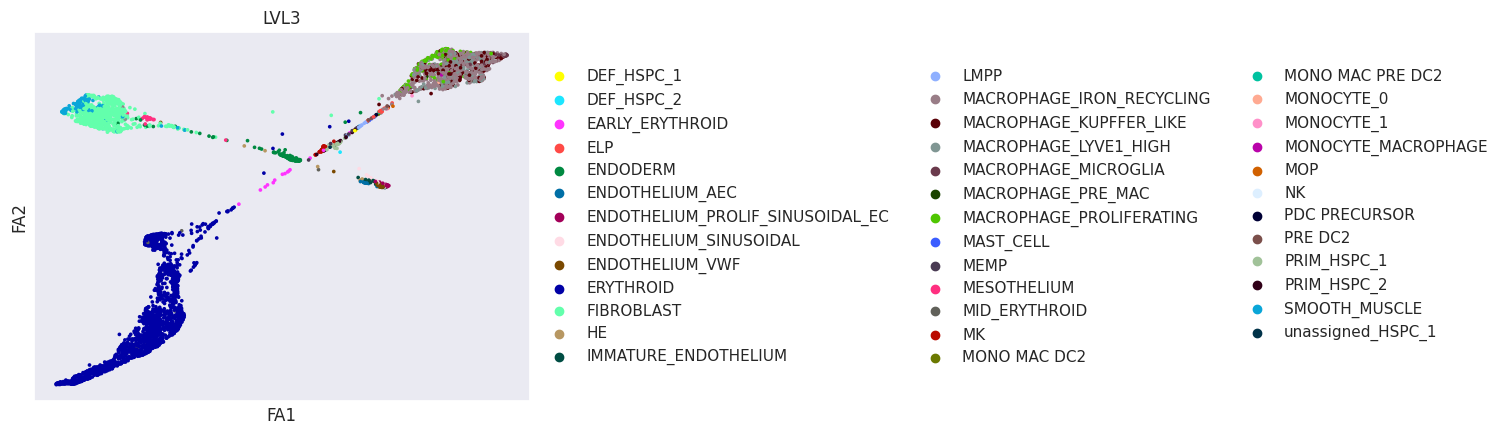

In [196]:
sc.pl.draw_graph(pseudobulk_adata_tt, color='LVL3')

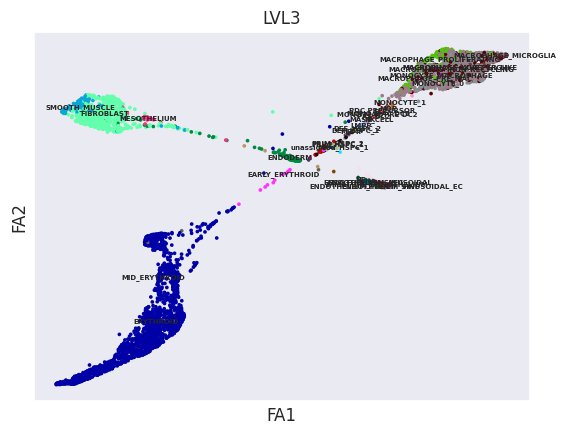

In [197]:
sc.pl.draw_graph(pseudobulk_adata_tt, color='LVL3',legend_loc='on data',legend_fontsize = 5)

# We can now compute mutual information gap (MIG) between Pseudocells and adata

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mutual_info_score

def calculate_mutual_information(pc1, pc2):
    """
    Calculate the mutual information between two principal components.
    """
    return mutual_info_score(pc1, pc2)

def calculate_entropy(pc):
    """
    Calculate the entropy of a principal component.
    """
    p_data = pc / np.sum(pc)
    entropy = -np.sum(p_data * np.log2(p_data + 1e-12))  # Adding a small value to avoid log(0)
    return entropy

def mutual_information_gap(adata_samp, adata, n_components=10):
    """
    Calculate the Mutual Information Gap (MIG) between the PCs of the sampled data
    and the original data.
    """
    # Align the datasets by selecting the same nodes
    adata = adata[adata_samp.obs.index, :]
    
# Write option to detect if PCs already available
#     # PCA on the sampled data
#     pca_samp = PCA(n_components=n_components)
#     pcs_samp = pca_samp.fit_transform(adata_samp.X)
    
#     # PCA on the original data
#     pca = PCA(n_components=n_components)
#     pcs = pca.fit_transform(adata.X)
    
    # Calculate mutual information and entropy
    mutual_informations = np.array([calculate_mutual_information(pcs_samp[:, i], pcs[:, i]) for i in range(n_components)])
    entropies = np.array([calculate_entropy(pcs[:, i]) for i in range(n_components)])
    
    # Normalize mutual information by entropy
    normalized_mi = mutual_informations / entropies
    
    # Calculate MIG
    mig = np.max(normalized_mi) - np.sort(normalized_mi)[-2]  # Subtract the second highest value from the max
    
    return mig

# Assuming 'adata_samp' and 'adata' are available Anndata objects with .X as their data matrix
# and they contain the same set of nodes, the following line would calculate MIG:
# mig_result = mutual_information_gap(adata_samp, adata)

In [ ]:
mig_result = mutual_information_gap(adata_samp, adata)